# Now lets pull in our user level metrics and grouped metrics tables and create final views

In [50]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3

In [51]:
# Path to your SQLite database
db_path = "Subscriptions.db"

# Connect to the database
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

# Find all metrics subscription data tables
cursor.execute("SELECT name FROM sqlite_master WHERE type='table' AND name LIKE 'metrics_subscription_data_%';")
tables = cursor.fetchall()

if not tables:
    print("No metrics_subscription_data tables found in the database.")
else:
    # Extract table names and sort them to find the most recent one
    metrics_tables = [table[0] for table in tables]
    latest_metrics_table = sorted(metrics_tables)[-1]
    
    print(f"Loading data from the most recent metrics table: '{latest_metrics_table}'")
    
    # Query to get all data from the most recent table
    query = f"SELECT * FROM {latest_metrics_table}"
    
    # Load the data into a pandas DataFrame
    df = pd.read_sql_query(query, conn)
    
    # Display basic information about the DataFrame
    print(f"\nLoaded {len(df)} rows and {len(df.columns)} columns")
    print("\nDataFrame shape:", df.shape)
    print("\nColumn names:", list(df.columns))
    print("\nFirst 5 rows:")
    print(df.head())
    
    # Show summary statistics for key metrics columns
    print("\nKey metrics summary:")
    metric_columns = ['payment_periods', 'avg_monthly_payment', 'expansion_ratio', 'has_expanded', 'current_mrr']
    print(df[metric_columns].describe())

# Close the connection
conn.close()

Loading data from the most recent metrics table: 'metrics_subscription_data_20230116'

Loaded 134610 rows and 21 columns

DataFrame shape: (134610, 21)

Column names: ['oid', 'provider', 'total_charges', 'signup_date', 'is_canceled', 'is_active', 'is_delinquent', 'conversion_date', 'cancellation_date', 'current_mrr', 'personal_person_geo_country', 'converted', 'payment_periods', 'avg_monthly_payment', 'expansion_ratio', 'has_expanded', 'price_tier', 'conversion_speed', 'conversion_speed_category', 'conversion_cohort', 'signup_cohort']

First 5 rows:
               oid provider  total_charges          signup_date  is_canceled  \
0  273624174263463    apple          10.94  2021-04-20 00:00:00            1   
1  532534633483904    apple          10.92  2021-04-20 00:00:00            1   
2  623527156674739    apple           0.00  2021-04-20 00:00:00            0   
3  441616357320658    apple          90.30  2021-04-20 00:00:00            0   
4  189644194376891    apple          79.98  

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


In [52]:
# Path to your SQLite database
db_path = "Subscriptions.db"

# Connect to the database
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

# Find all metrics subscription data tables
cursor.execute("SELECT name FROM sqlite_master WHERE type='table' AND name LIKE 'grouped_metrics_subscription_data_%';")
tables = cursor.fetchall()

if not tables:
    print("No metrics_subscription_data tables found in the database.")
else:
    # Extract table names and sort them to find the most recent one
    grouped_metrics_tables = [table[0] for table in tables]
    grouped_latest_metrics_table = sorted(grouped_metrics_tables)[-1]
    
    print(f"Loading data from the most recent metrics table: '{grouped_latest_metrics_table}'")
    
    # Query to get all data from the most recent table
    query = f"SELECT * FROM {grouped_latest_metrics_table}"
    
    # Load the data into a pandas DataFrame
    grouped_df = pd.read_sql_query(query, conn)
    
    # Display basic information about the DataFrame
    print(f"\nLoaded {len(grouped_df)} rows and {len(grouped_df.columns)} columns")
    print("\nDataFrame shape:", grouped_df.shape)
    print("\nColumn names:", list(grouped_df.columns))
    print("\nFirst 5 rows:")
    print(grouped_df.head())
    
    

# Close the connection
conn.close()

Loading data from the most recent metrics table: 'grouped_metrics_subscription_data_2023_01'

Loaded 16025 rows and 18 columns

DataFrame shape: (16025, 18)

Column names: ['provider', 'is_active', 'is_canceled', 'converted', 'personal_person_geo_country', 'price_tier', 'conversion_speed_category', 'conversion_cohort', 'signup_cohort', 'customer_count', 'total_charges_sum', 'avg_total_charges', 'avg_current_mrr', 'avg_payment_periods', 'avg_of_avg_monthly_payment', 'sum_avg_monthly_payment', 'avg_expansion_ratio', 'avg_conversion_speed']

First 5 rows:
  provider  is_active  is_canceled  converted personal_person_geo_country  \
0    apple          1            0          1    United States of America   
1    apple          1            0          1    United States of America   
2    apple          1            0          1    United States of America   
3    apple          1            0          1    United States of America   
4    apple          1            0          1    United 

### Lets look at performance and retention across the starting cohorts
- We can look at both the signup cohorts and the conversion date cohorts 

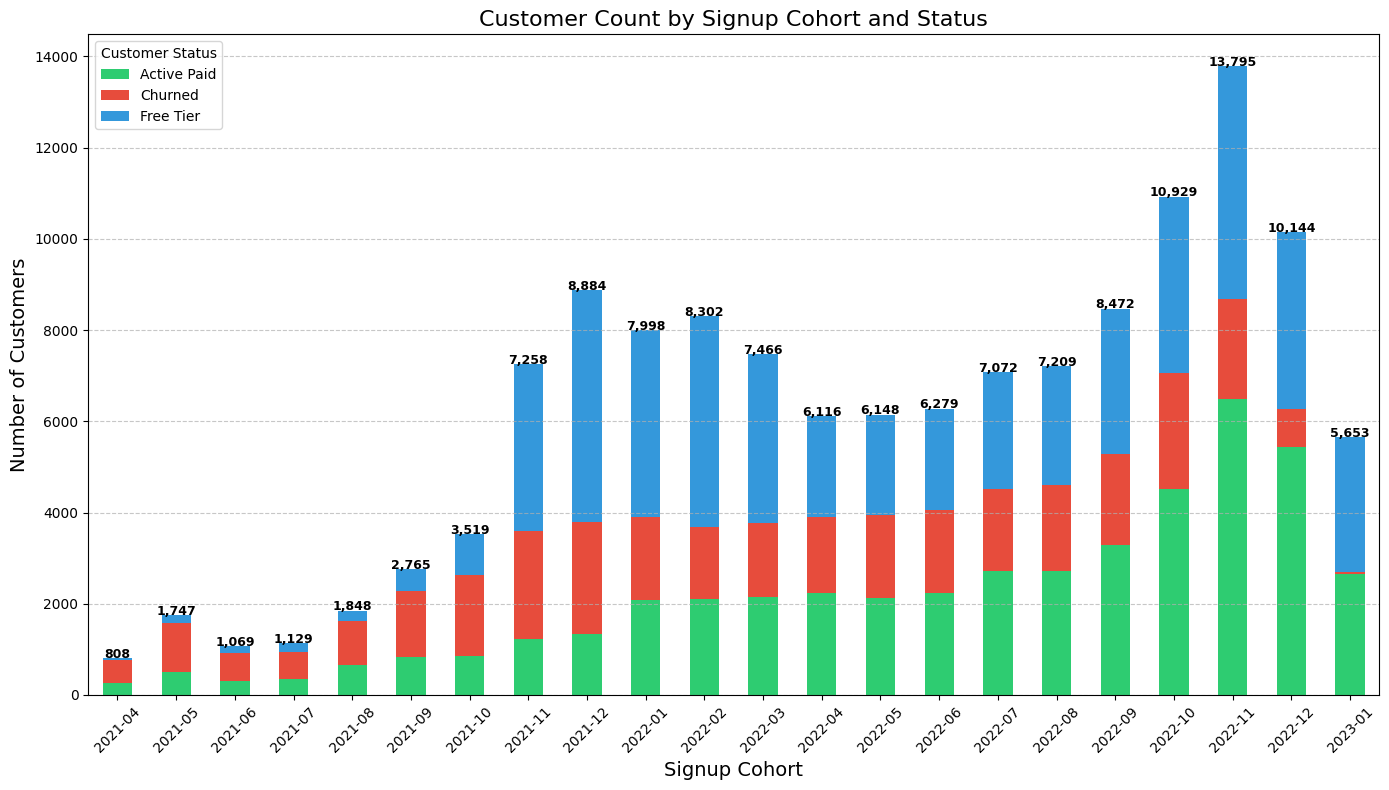

Customer counts by signup cohort and status:
status         Active Paid  Churned  Free Tier
signup_cohort                                 
2021-04                253      504         51
2021-05                502     1075        170
2021-06                313      610        146
2021-07                351      602        176
2021-08                647      978        223
2021-09                833     1443        489
2021-10                850     1782        887
2021-11               1217     2370       3671
2021-12               1336     2453       5095
2022-01               2092     1820       4086
2022-02               2114     1577       4611
2022-03               2157     1605       3704
2022-04               2232     1673       2211
2022-05               2136     1804       2208
2022-06               2233     1827       2219
2022-07               2712     1799       2561
2022-08               2716     1886       2607
2022-09               3283     2010       3179
2022-10        

In [53]:
# Group data by signup cohort and customer status
cohort_status = grouped_df.groupby(['signup_cohort', 'is_active', 'is_canceled', 'converted'])['customer_count'].sum().reset_index()
#cohort_status

# Create new column for customer status
def get_status(row):
    if row['is_active'] == 1 and row['converted'] == 1:
        return 'Active Paid'
    elif row['is_canceled'] == 1:
        return 'Churned'
    else:
        return 'Free Tier'

cohort_status['status'] = cohort_status.apply(get_status, axis=1)

# Pivot table for plotting
cohort_pivot = pd.pivot_table(
    cohort_status, 
    values='customer_count',
    index='signup_cohort',
    columns='status',
    aggfunc='sum',
    fill_value=0
)

# Ensure all status categories exist
for status in ['Active Paid', 'Churned', 'Free Tier']:
    if status not in cohort_pivot.columns:
        cohort_pivot[status] = 0

# Sort by cohort date
cohort_pivot = cohort_pivot.sort_index()

# Create stacked bar chart
plt.figure(figsize=(14, 8))
cohort_pivot.plot(
    kind='bar', 
    stacked=True,
    color=['#2ecc71', '#e74c3c', '#3498db'],  # Green for active, red for churned, blue for free
    ax=plt.gca()
)

# Add total count on top of each bar
for i, cohort in enumerate(cohort_pivot.index):
    total = cohort_pivot.loc[cohort].sum()
    plt.text(i, total + 5, f'{int(total):,}', ha='center', fontsize=9, fontweight='bold')

plt.title('Customer Count by Signup Cohort and Status', fontsize=16)
plt.xlabel('Signup Cohort', fontsize=14)
plt.ylabel('Number of Customers', fontsize=14)
plt.legend(title='Customer Status')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Display the data table
print("Customer counts by signup cohort and status:")
print(cohort_pivot)

## Now lets look at the conversion speed 

/var/folders/7k/wrk7c3wx3pl7px430tg547rr0000gn/T/ipykernel_98169/3948396145.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  conversion_lifetime = converted_df.groupby('signup_cohort').apply(lambda x: pd.Series({


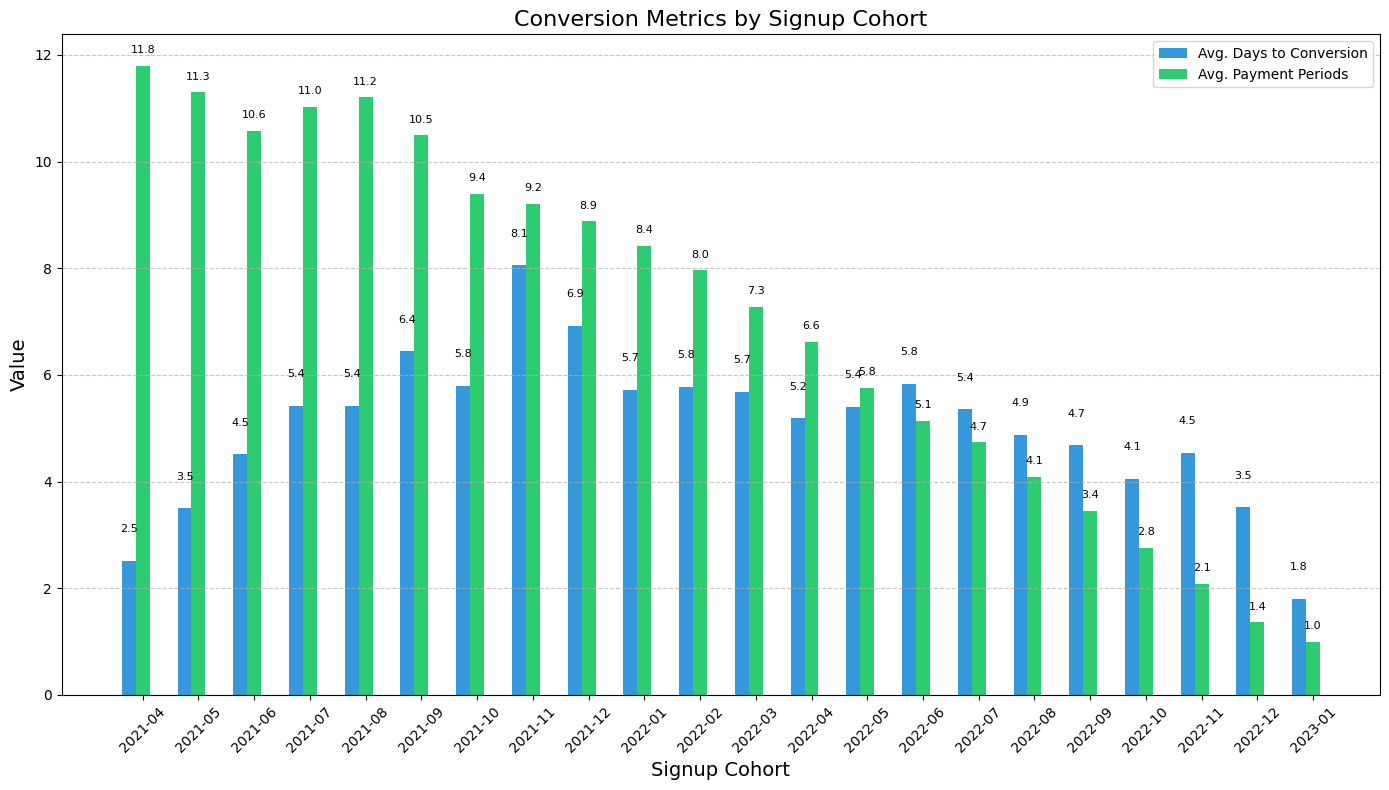

In [54]:
# Analyze average conversion period, average lifetime, and unconverted population percentage by signup cohort
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Filter to include only converted customers for conversion speed and payment periods
converted_df = grouped_df[grouped_df['converted'] == 1]

# Group by signup cohort to calculate averages for converted customers
# Use customer_count as weights for proper weighting of averages
conversion_lifetime = converted_df.groupby('signup_cohort').apply(lambda x: pd.Series({
    'avg_conversion_speed': np.average(x['avg_conversion_speed'], weights=x['customer_count']),
    'avg_payment_periods': np.average(x['avg_payment_periods'], weights=x['customer_count']),
    'converted_count': x['customer_count'].sum()
})).reset_index()

# Calculate conversion rate for each cohort
cohort_totals = grouped_df.groupby('signup_cohort')['customer_count'].sum().reset_index()
cohort_totals.columns = ['signup_cohort', 'total_count']

# Merge to get both total and converted counts
conversion_metrics = pd.merge(conversion_lifetime, cohort_totals, on='signup_cohort', how='right')
conversion_metrics['conversion_rate'] = (conversion_metrics['converted_count'] / conversion_metrics['total_count']) * 100
conversion_metrics['unconverted_percent'] = 100 - conversion_metrics['conversion_rate']
conversion_metrics = conversion_metrics.fillna(0)  # Fill NaN values with 0

# Sort by cohort date
conversion_metrics = conversion_metrics.sort_values('signup_cohort')

# Create a figure for the combined visualization
plt.figure(figsize=(14, 8))

# Set width of bars
barWidth = 0.25
r1 = np.arange(len(conversion_metrics))
r2 = [x + barWidth for x in r1]
# r3 = [x + barWidth for x in r2]

# Create bars
conversion_bars = plt.bar(
    r1, 
    conversion_metrics['avg_conversion_speed'], 
    width=barWidth, 
    color='#3498db', 
    label='Avg. Days to Conversion'
)
lifetime_bars = plt.bar(
    r2, 
    conversion_metrics['avg_payment_periods'], 
    width=barWidth, 
    color='#2ecc71', 
    label='Avg. Payment Periods'
)
# unconverted_bars = plt.bar(
#     r3, 
#     conversion_metrics['unconverted_percent'], 
#     width=barWidth, 
#     color='#e74c3c', 
#     label='Unconverted Population (%)'
# )

# Add data labels on top of bars
for i, bar in enumerate(conversion_bars):
    height = bar.get_height()
    if height > 0:
        plt.text(
            bar.get_x() + bar.get_width()/2., 
            height + 0.5, 
            f'{height:.1f}',
            ha='center', 
            va='bottom', 
            fontsize=8
        )
    
for i, bar in enumerate(lifetime_bars):
    height = bar.get_height()
    if height > 0:
        plt.text(
            bar.get_x() + bar.get_width()/2., 
            height + 0.2, 
            f'{height:.1f}',
            ha='center', 
            va='bottom', 
            fontsize=8
        )

# for i, bar in enumerate(unconverted_bars):
#     height = bar.get_height()
#     if height > 0:
#         plt.text(
#             bar.get_x() + bar.get_width()/2., 
#             height + 1, 
#             f'{height:.1f}%',
#             ha='center', 
#             va='bottom', 
#             fontsize=8
#         )

# Add labels and legend
plt.title('Conversion Metrics by Signup Cohort', fontsize=16)
plt.xlabel('Signup Cohort', fontsize=14)
plt.ylabel('Value', fontsize=14)
plt.xticks([r + barWidth for r in range(len(conversion_metrics))], conversion_metrics['signup_cohort'], rotation=45)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


/var/folders/7k/wrk7c3wx3pl7px430tg547rr0000gn/T/ipykernel_98169/1965519073.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  cohort_retention = converted_df.groupby('conversion_cohort').apply(lambda x: pd.Series({


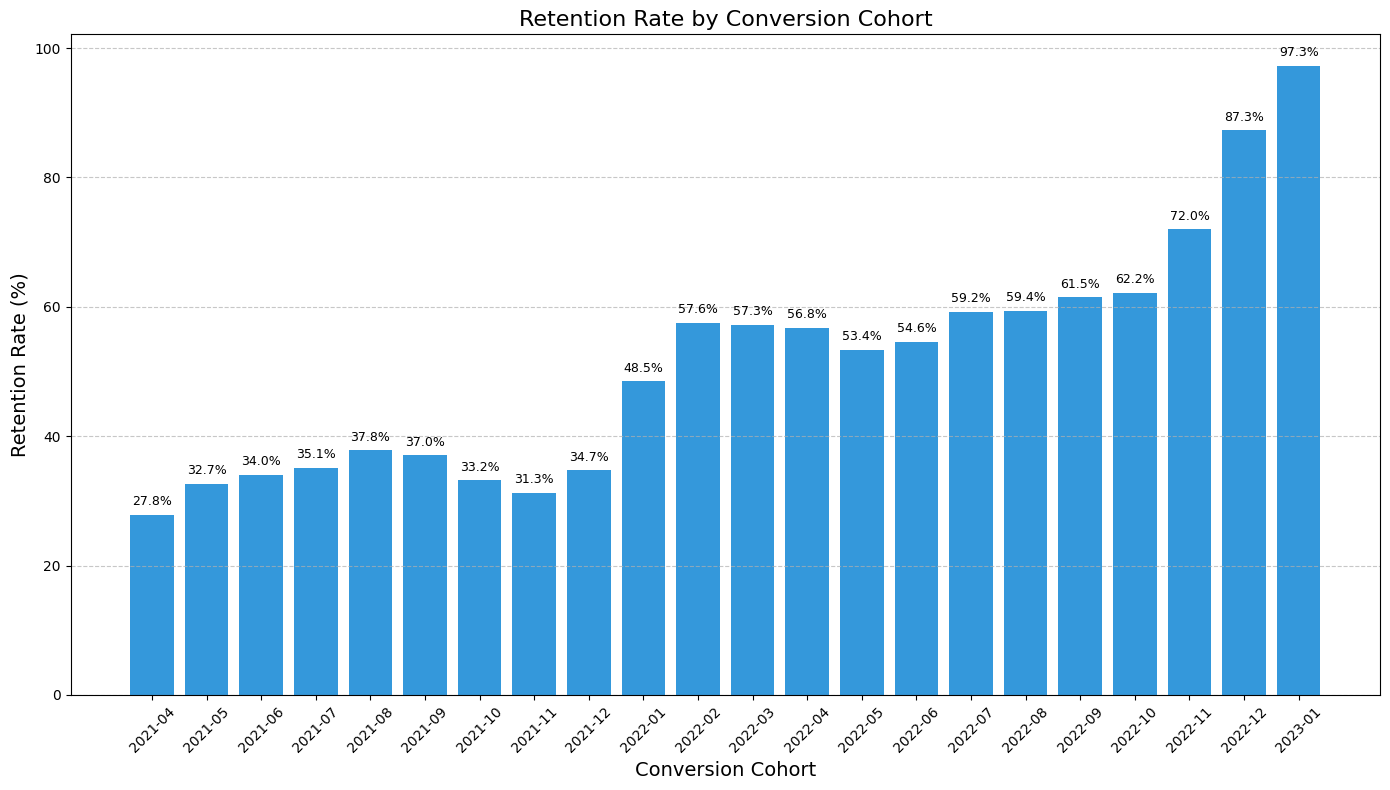

Retention rate by conversion cohort:
   conversion_cohort  total_customers  active_customers  retention_rate
0            2021-04            636.0             177.0           27.83
1            2021-05           1561.0             510.0           32.67
2            2021-06            967.0             329.0           34.02
3            2021-07            897.0             315.0           35.12
4            2021-08           1496.0             566.0           37.83
5            2021-09           2109.0             781.0           37.03
6            2021-10           2697.0             896.0           33.22
7            2021-11           3215.0            1006.0           31.29
8            2021-12           4013.0            1394.0           34.74
9            2022-01           3809.0            1846.0           48.46
10           2022-02           3708.0            2134.0           57.55
11           2022-03           3804.0            2178.0           57.26
12           2022-04       

In [55]:
# Simple retention rate analysis by conversion cohort
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Filter to include only converted customers
converted_df = grouped_df[grouped_df['converted'] == 1]

# Calculate retention rate for each conversion cohort
cohort_retention = converted_df.groupby('conversion_cohort').apply(lambda x: pd.Series({
    'total_customers': x['customer_count'].sum(),
    'active_customers': x[x['is_active'] == 1]['customer_count'].sum(),
    'retention_rate': (x[x['is_active'] == 1]['customer_count'].sum() / x['customer_count'].sum()) * 100
})).reset_index()

# Sort by cohort date
cohort_retention = cohort_retention.sort_values('conversion_cohort')

# Create bar chart
plt.figure(figsize=(14, 8))

# Plot retention rate
bars = plt.bar(
    cohort_retention['conversion_cohort'],
    cohort_retention['retention_rate'],
    color='#3498db'
)

# Add data labels on top of bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2., 
        height + 1, 
        f'{height:.1f}%',
        ha='center', 
        va='bottom', 
        fontsize=9
    )

plt.title('Retention Rate by Conversion Cohort', fontsize=16)
plt.xlabel('Conversion Cohort', fontsize=14)
plt.ylabel('Retention Rate (%)', fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Display the data
print("Retention rate by conversion cohort:")
print(cohort_retention[['conversion_cohort', 'total_customers', 'active_customers', 'retention_rate']].round(2))

/var/folders/7k/wrk7c3wx3pl7px430tg547rr0000gn/T/ipykernel_98169/2305597148.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  cohort_retention = converted_df.groupby('signup_cohort').apply(lambda x: pd.Series({


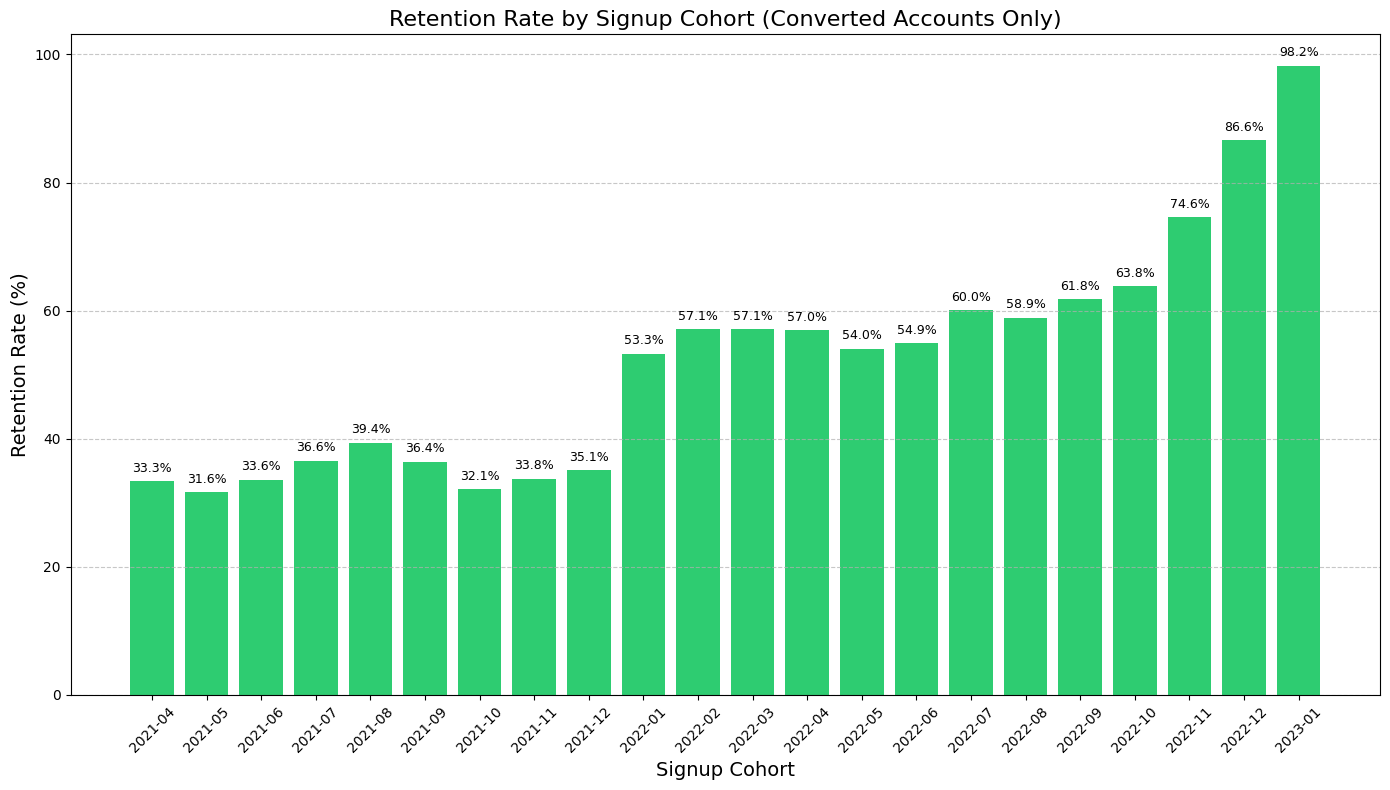

Retention rate by signup cohort (converted accounts only):
   signup_cohort  total_customers  active_customers  retention_rate
0        2021-04            759.0             253.0           33.33
1        2021-05           1587.0             502.0           31.63
2        2021-06            932.0             313.0           33.58
3        2021-07            959.0             351.0           36.60
4        2021-08           1642.0             647.0           39.40
5        2021-09           2287.0             833.0           36.42
6        2021-10           2645.0             850.0           32.14
7        2021-11           3602.0            1217.0           33.79
8        2021-12           3809.0            1336.0           35.07
9        2022-01           3927.0            2092.0           53.27
10       2022-02           3704.0            2114.0           57.07
11       2022-03           3775.0            2157.0           57.14
12       2022-04           3919.0            2232.0      

In [56]:
# Retention rate analysis by signup cohort (for converted accounts only)
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Filter to include only converted customers
converted_df = grouped_df[grouped_df['converted'] == 1]

# Calculate retention rate for each signup cohort
cohort_retention = converted_df.groupby('signup_cohort').apply(lambda x: pd.Series({
    'total_customers': x['customer_count'].sum(),
    'active_customers': x[x['is_active'] == 1]['customer_count'].sum(),
    'retention_rate': (x[x['is_active'] == 1]['customer_count'].sum() / x['customer_count'].sum()) * 100
})).reset_index()

# Sort by cohort date
cohort_retention = cohort_retention.sort_values('signup_cohort')

# Create bar chart
plt.figure(figsize=(14, 8))

# Plot retention rate
bars = plt.bar(
    cohort_retention['signup_cohort'],
    cohort_retention['retention_rate'],
    color='#2ecc71'  # Different color from conversion cohort chart
)

# Add data labels on top of bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2., 
        height + 1, 
        f'{height:.1f}%',
        ha='center', 
        va='bottom', 
        fontsize=9
    )

plt.title('Retention Rate by Signup Cohort (Converted Accounts Only)', fontsize=16)
plt.xlabel('Signup Cohort', fontsize=14)
plt.ylabel('Retention Rate (%)', fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Display the data
print("Retention rate by signup cohort (converted accounts only):")
print(cohort_retention[['signup_cohort', 'total_customers', 'active_customers', 'retention_rate']].round(2))

/var/folders/7k/wrk7c3wx3pl7px430tg547rr0000gn/T/ipykernel_98169/1315749299.py:27: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  retention_by_tier = converted_df.groupby(['signup_cohort', 'simple_price_tier']).apply(lambda x: pd.Series({


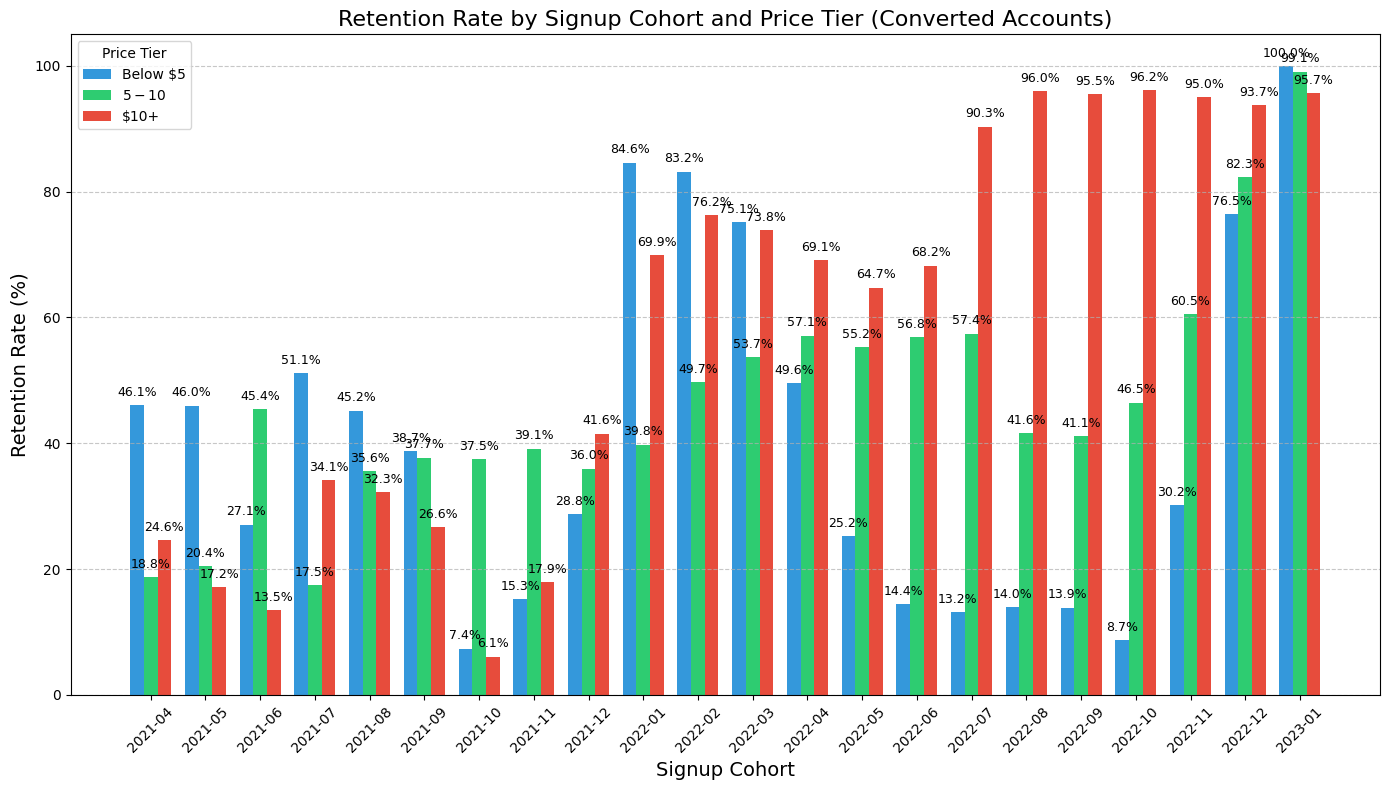

Retention rate by signup cohort and price tier (converted accounts only):

Retention Rate (%):
simple_price_tier  $10+  $5-$10  Below $5
signup_cohort                            
2021-04            24.6    18.8      46.1
2021-05            17.2    20.4      46.0
2021-06            13.5    45.4      27.1
2021-07            34.1    17.5      51.1
2021-08            32.3    35.6      45.2
2021-09            26.6    37.7      38.7
2021-10             6.1    37.5       7.4
2021-11            17.9    39.1      15.3
2021-12            41.6    36.0      28.8
2022-01            69.9    39.8      84.6
2022-02            76.2    49.7      83.2
2022-03            73.8    53.7      75.1
2022-04            69.1    57.1      49.6
2022-05            64.7    55.2      25.2
2022-06            68.2    56.8      14.4
2022-07            90.3    57.4      13.2
2022-08            96.0    41.6      14.0
2022-09            95.5    41.1      13.9
2022-10            96.2    46.5       8.7
2022-11            95.0

In [57]:
# Retention rate analysis by signup cohort and price tier (for converted accounts only)
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Filter to include only converted customers
converted_df = grouped_df[grouped_df['converted'] == 1].copy()

# Create simplified price tier categories
def simplify_price_tier(tier):
    if tier is None or pd.isna(tier):
        return 'Unknown'
    # Check if the tier is below $5
    elif any(x in tier for x in ['$2.50-$5']):
        return 'Below $5'
    # Check if the tier is between $5 and $10
    elif any(x in tier for x in ['$5-$7.50', '$7.50-$10']):
        return '$5-$10'
    # Everything else is $10+
    else:
        return '$10+'

# Add the simplified price tier column
converted_df['simple_price_tier'] = converted_df['price_tier'].apply(simplify_price_tier)

# Calculate retention rate for each signup cohort and price tier
retention_by_tier = converted_df.groupby(['signup_cohort', 'simple_price_tier']).apply(lambda x: pd.Series({
    'total_customers': x['customer_count'].sum(),
    'active_customers': x[x['is_active'] == 1]['customer_count'].sum(),
    'retention_rate': (x[x['is_active'] == 1]['customer_count'].sum() / x['customer_count'].sum()) * 100
})).reset_index()

# Filter out the 'Unknown' price tier if present
retention_by_tier = retention_by_tier[retention_by_tier['simple_price_tier'] != 'Unknown']

# Sort by cohort date
retention_by_tier = retention_by_tier.sort_values('signup_cohort')

# Create bar chart
plt.figure(figsize=(14, 8))

# Set up the grouped bars
cohorts = retention_by_tier['signup_cohort'].unique()
tiers = ['Below $5', '$5-$10', '$10+']
x = np.arange(len(cohorts))
width = 0.25

# Colors for each price tier
colors = {
    'Below $5': '#3498db',  # Blue
    '$5-$10': '#2ecc71',    # Green
    '$10+': '#e74c3c'       # Red
}

# Create a bar for each price tier
for i, tier in enumerate(tiers):
    # Get data for this tier
    tier_data = retention_by_tier[retention_by_tier['simple_price_tier'] == tier]
    
    # Prepare data for all cohorts (fill missing with zeros)
    retention_rates = []
    for cohort in cohorts:
        cohort_tier_data = tier_data[tier_data['signup_cohort'] == cohort]
        if len(cohort_tier_data) > 0:
            retention_rates.append(cohort_tier_data['retention_rate'].values[0])
        else:
            retention_rates.append(0)
    
    # Plot the bars for this tier
    bars = plt.bar(
        x + (i - 1) * width, 
        retention_rates, 
        width, 
        label=tier,
        color=colors[tier]
    )
    
    # Add data labels on top of bars
    for j, bar in enumerate(bars):
        height = bar.get_height()
        if height > 0:
            plt.text(
                bar.get_x() + bar.get_width()/2.,
                height + 1,
                f'{height:.1f}%',
                ha='center',
                va='bottom',
                fontsize=9
            )

plt.title('Retention Rate by Signup Cohort and Price Tier (Converted Accounts)', fontsize=16)
plt.xlabel('Signup Cohort', fontsize=14)
plt.ylabel('Retention Rate (%)', fontsize=14)
plt.xticks(x, cohorts, rotation=45)
plt.legend(title='Price Tier')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Display the data
print("Retention rate by signup cohort and price tier (converted accounts only):")
retention_pivot = retention_by_tier.pivot_table(
    values=['retention_rate', 'total_customers'],
    index='signup_cohort',
    columns='simple_price_tier'
)

# Format the output table for better readability
print("\nRetention Rate (%):")
print(retention_pivot['retention_rate'].round(1))

print("\nSample Size (n):")
print(retention_pivot['total_customers'].astype(int))

/var/folders/7k/wrk7c3wx3pl7px430tg547rr0000gn/T/ipykernel_98169/2282064012.py:34: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  retention_by_tier = converted_df.groupby(['signup_quarter', 'simple_price_tier']).apply(lambda x: pd.Series({


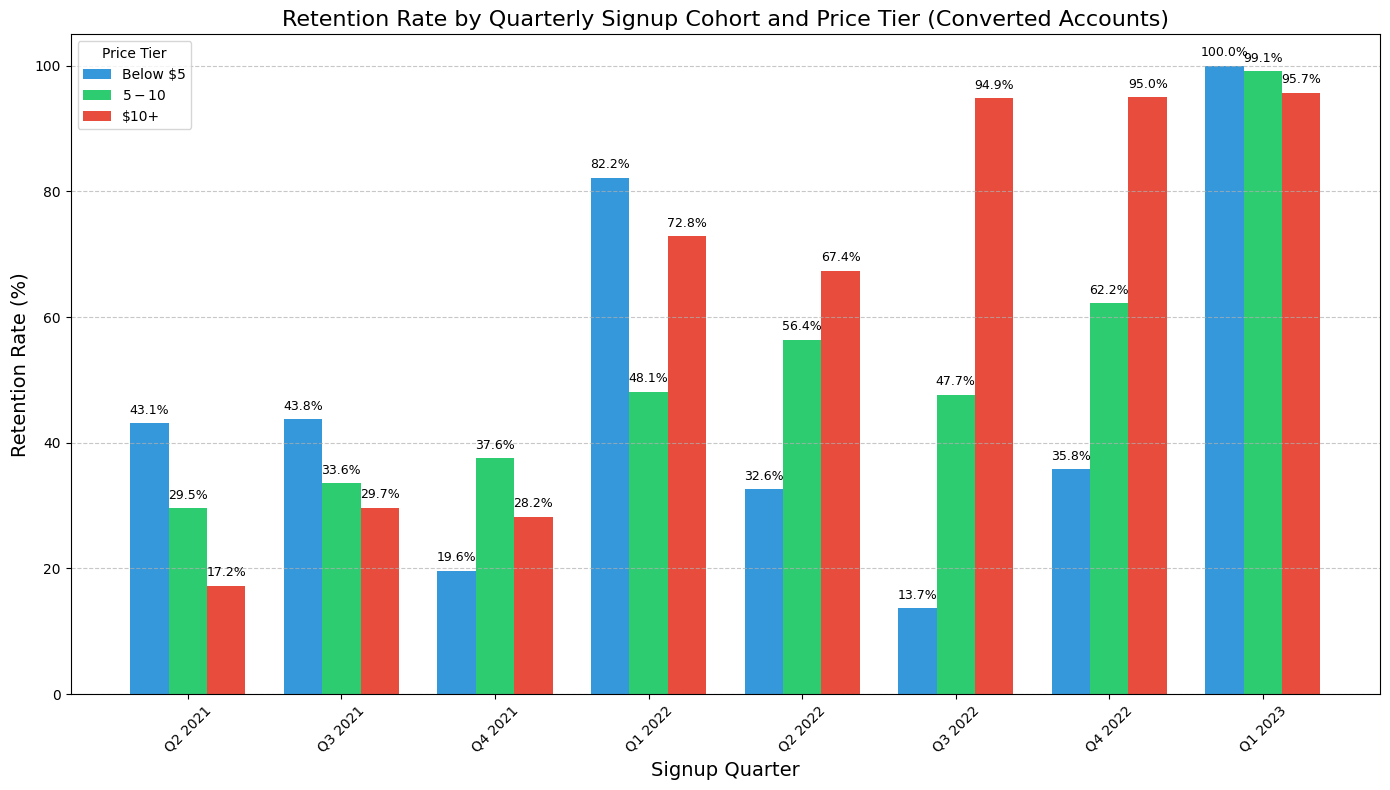

Retention rate (%) by quarterly cohort and price tier:
simple_price_tier  $10+  $5-$10  Below $5
signup_quarter                           
Q2 2021            17.2    29.5      43.1
Q3 2021            29.7    33.6      43.8
Q4 2021            28.2    37.6      19.6
Q1 2022            72.8    48.1      82.2
Q2 2022            67.4    56.4      32.6
Q3 2022            94.9    47.7      13.7
Q4 2022            95.0    62.2      35.8
Q1 2023            95.7    99.1     100.0

Sample size (n) by quarterly cohort and price tier:
simple_price_tier  $10+  $5-$10  Below $5
signup_quarter                           
Q2 2021             638    1324      1316
Q3 2021             671    2106      2111
Q4 2021             694    7634      1728
Q1 2022             931    8592      1883
Q2 2022             604   10504       831
Q3 2022            4491    9088       861
Q4 2022            9268   11588      1197
Q1 2023             698    1968        33


In [58]:
# Retention rate analysis by quarterly signup cohort and price tier (for converted accounts only)
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Filter to include only converted customers
converted_df = grouped_df[grouped_df['converted'] == 1].copy()

# Create simplified price tier categories
def simplify_price_tier(tier):
    if tier is None or pd.isna(tier):
        return 'Unknown'
    # Check if the tier is below $5
    elif any(x in tier for x in ['$2.50-$5']):
        return 'Below $5'
    # Check if the tier is between $5 and $10
    elif any(x in tier for x in ['$5-$7.50', '$7.50-$10']):
        return '$5-$10'
    # Everything else is $10+
    else:
        return '$10+'

# Add the simplified price tier column
converted_df['simple_price_tier'] = converted_df['price_tier'].apply(simplify_price_tier)

# Convert monthly cohorts to quarterly cohorts
def get_quarter(month_str):
    date = pd.to_datetime(month_str + '-01')
    return f"Q{(date.month-1)//3+1} {date.year}"

converted_df['signup_quarter'] = converted_df['signup_cohort'].apply(get_quarter)

# Calculate retention rate for each quarterly signup cohort and price tier
retention_by_tier = converted_df.groupby(['signup_quarter', 'simple_price_tier']).apply(lambda x: pd.Series({
    'total_customers': x['customer_count'].sum(),
    'active_customers': x[x['is_active'] == 1]['customer_count'].sum(),
    'retention_rate': (x[x['is_active'] == 1]['customer_count'].sum() / x['customer_count'].sum()) * 100
})).reset_index()

# Filter out the 'Unknown' price tier if present
retention_by_tier = retention_by_tier[retention_by_tier['simple_price_tier'] != 'Unknown']

# Sort quarters chronologically 
def quarter_sort_key(q):
    parts = q.split()
    year = int(parts[1])
    quarter = int(parts[0][1])
    return year * 10 + quarter

# Create a sorted list of quarters
all_quarters = sorted(retention_by_tier['signup_quarter'].unique(), key=quarter_sort_key)

# Create bar chart
plt.figure(figsize=(14, 8))

# Set up the grouped bars
x = np.arange(len(all_quarters))
width = 0.25

# Colors for each price tier
colors = {
    'Below $5': '#3498db',  # Blue
    '$5-$10': '#2ecc71',    # Green
    '$10+': '#e74c3c'       # Red
}

# Price tiers in order
tiers = ['Below $5', '$5-$10', '$10+']

# Create a bar for each price tier
for i, tier in enumerate(tiers):
    # Get data for this tier
    tier_data = retention_by_tier[retention_by_tier['simple_price_tier'] == tier]
    
    # Prepare data for all quarters (fill missing with zeros)
    retention_rates = []
    for quarter in all_quarters:
        quarter_tier_data = tier_data[tier_data['signup_quarter'] == quarter]
        if len(quarter_tier_data) > 0:
            retention_rates.append(quarter_tier_data['retention_rate'].values[0])
        else:
            retention_rates.append(0)
    
    # Plot the bars for this tier
    bars = plt.bar(
        x + (i - 1) * width, 
        retention_rates, 
        width, 
        label=tier,
        color=colors[tier]
    )
    
    # Add data labels on top of bars
    for j, bar in enumerate(bars):
        height = bar.get_height()
        if height > 0:
            plt.text(
                bar.get_x() + bar.get_width()/2.,
                height + 1,
                f'{height:.1f}%',
                ha='center',
                va='bottom',
                fontsize=9
            )

plt.title('Retention Rate by Quarterly Signup Cohort and Price Tier (Converted Accounts)', fontsize=16)
plt.xlabel('Signup Quarter', fontsize=14)
plt.ylabel('Retention Rate (%)', fontsize=14)
plt.xticks(x, all_quarters, rotation=45)
plt.legend(title='Price Tier')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Display the data
# Create pivot table for retention rates
retention_pivot = pd.pivot_table(
    retention_by_tier,
    values='retention_rate',
    index='signup_quarter',
    columns='simple_price_tier'
)

# Create pivot table for customer counts
count_pivot = pd.pivot_table(
    retention_by_tier,
    values='total_customers',
    index='signup_quarter',
    columns='simple_price_tier'
)

# Sort both tables by quarter
retention_pivot = retention_pivot.loc[all_quarters]
count_pivot = count_pivot.loc[all_quarters]

# Format the output tables for better readability
print("Retention rate (%) by quarterly cohort and price tier:")
print(retention_pivot.round(1))

print("\nSample size (n) by quarterly cohort and price tier:")
print(count_pivot.astype(int))

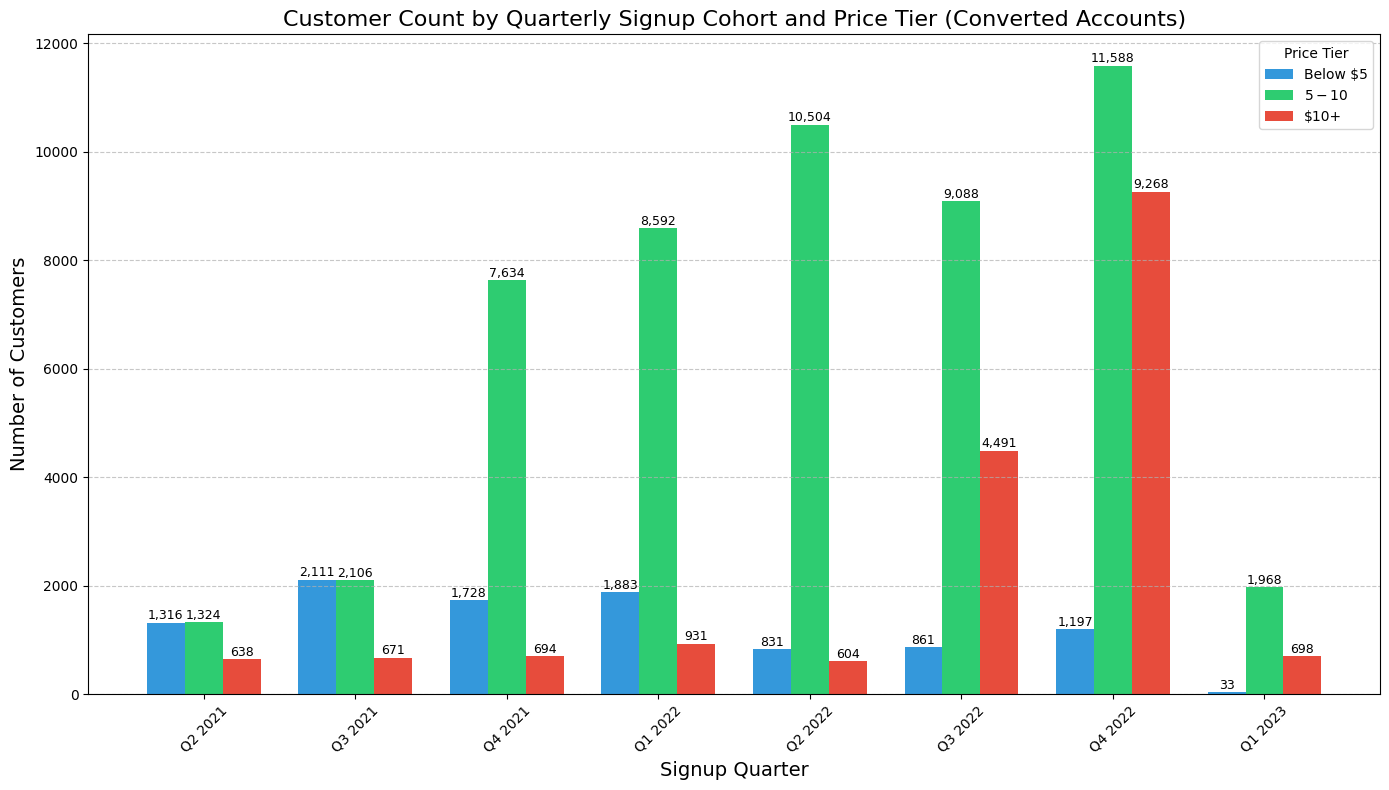

Customer count by quarterly cohort and price tier:
simple_price_tier  $10+  $5-$10  Below $5
signup_quarter                           
Q2 2021             638    1324      1316
Q3 2021             671    2106      2111
Q4 2021             694    7634      1728
Q1 2022             931    8592      1883
Q2 2022             604   10504       831
Q3 2022            4491    9088       861
Q4 2022            9268   11588      1197
Q1 2023             698    1968        33

Percentage distribution by quarterly cohort and price tier:
simple_price_tier  $10+  $5-$10  Below $5
signup_quarter                           
Q2 2021            19.5    40.4      40.1
Q3 2021            13.7    43.1      43.2
Q4 2021             6.9    75.9      17.2
Q1 2022             8.2    75.3      16.5
Q2 2022             5.1    88.0       7.0
Q3 2022            31.1    62.9       6.0
Q4 2022            42.0    52.5       5.4
Q1 2023            25.9    72.9       1.2


In [59]:
# Analysis of customer counts by quarterly signup cohort and price tier
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Filter to include only converted customers
converted_df = grouped_df[grouped_df['converted'] == 1].copy()

# Create simplified price tier categories
def simplify_price_tier(tier):
    if tier is None or pd.isna(tier):
        return 'Unknown'
    # Check if the tier is below $5
    elif any(x in tier for x in ['$2.50-$5']):
        return 'Below $5'
    # Check if the tier is between $5 and $10
    elif any(x in tier for x in ['$5-$7.50', '$7.50-$10']):
        return '$5-$10'
    # Everything else is $10+
    else:
        return '$10+'

# Add the simplified price tier column
converted_df['simple_price_tier'] = converted_df['price_tier'].apply(simplify_price_tier)

# Convert monthly cohorts to quarterly cohorts
def get_quarter(month_str):
    date = pd.to_datetime(month_str + '-01')
    return f"Q{(date.month-1)//3+1} {date.year}"

converted_df['signup_quarter'] = converted_df['signup_cohort'].apply(get_quarter)

# Aggregate customer counts by quarter and price tier
customer_counts = converted_df.groupby(['signup_quarter', 'simple_price_tier'])['customer_count'].sum().reset_index()

# Filter out the 'Unknown' price tier if present
customer_counts = customer_counts[customer_counts['simple_price_tier'] != 'Unknown']

# Sort quarters chronologically 
def quarter_sort_key(q):
    parts = q.split()
    year = int(parts[1])
    quarter = int(parts[0][1])
    return year * 10 + quarter

# Create a sorted list of quarters
all_quarters = sorted(customer_counts['signup_quarter'].unique(), key=quarter_sort_key)

# Create bar chart
plt.figure(figsize=(14, 8))

# Set up the grouped bars
x = np.arange(len(all_quarters))
width = 0.25

# Colors for each price tier
colors = {
    'Below $5': '#3498db',  # Blue
    '$5-$10': '#2ecc71',    # Green
    '$10+': '#e74c3c'       # Red
}

# Price tiers in order
tiers = ['Below $5', '$5-$10', '$10+']

# Create a bar for each price tier
for i, tier in enumerate(tiers):
    # Get data for this tier
    tier_data = customer_counts[customer_counts['simple_price_tier'] == tier]
    
    # Prepare data for all quarters (fill missing with zeros)
    count_values = []
    for quarter in all_quarters:
        quarter_tier_data = tier_data[tier_data['signup_quarter'] == quarter]
        if len(quarter_tier_data) > 0:
            count_values.append(quarter_tier_data['customer_count'].values[0])
        else:
            count_values.append(0)
    
    # Plot the bars for this tier
    bars = plt.bar(
        x + (i - 1) * width, 
        count_values, 
        width, 
        label=tier,
        color=colors[tier]
    )
    
    # Add data labels on top of bars
    for j, bar in enumerate(bars):
        height = bar.get_height()
        if height > 0:
            plt.text(
                bar.get_x() + bar.get_width()/2.,
                height + 5,
                f'{int(height):,}',
                ha='center',
                va='bottom',
                fontsize=9
            )

plt.title('Customer Count by Quarterly Signup Cohort and Price Tier (Converted Accounts)', fontsize=16)
plt.xlabel('Signup Quarter', fontsize=14)
plt.ylabel('Number of Customers', fontsize=14)
plt.xticks(x, all_quarters, rotation=45)
plt.legend(title='Price Tier')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Create pivot table for customer counts
count_pivot = pd.pivot_table(
    customer_counts,
    values='customer_count',
    index='signup_quarter',
    columns='simple_price_tier'
)

# Sort table by quarter
count_pivot = count_pivot.loc[all_quarters]

# Display the data
print("Customer count by quarterly cohort and price tier:")
print(count_pivot.astype(int))

# Calculate the percentage distribution
percent_pivot = count_pivot.div(count_pivot.sum(axis=1), axis=0) * 100

print("\nPercentage distribution by quarterly cohort and price tier:")
print(percent_pivot.round(1))

/var/folders/7k/wrk7c3wx3pl7px430tg547rr0000gn/T/ipykernel_98169/2044999023.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  provider_mrr = provider_data.groupby('signup_month').apply(
/var/folders/7k/wrk7c3wx3pl7px430tg547rr0000gn/T/ipykernel_98169/2044999023.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  provider_mrr = provider_data.groupby('signup_month').apply(
/var/folders/7k/wrk7c3wx3pl7px43

<Figure size 1600x800 with 0 Axes>

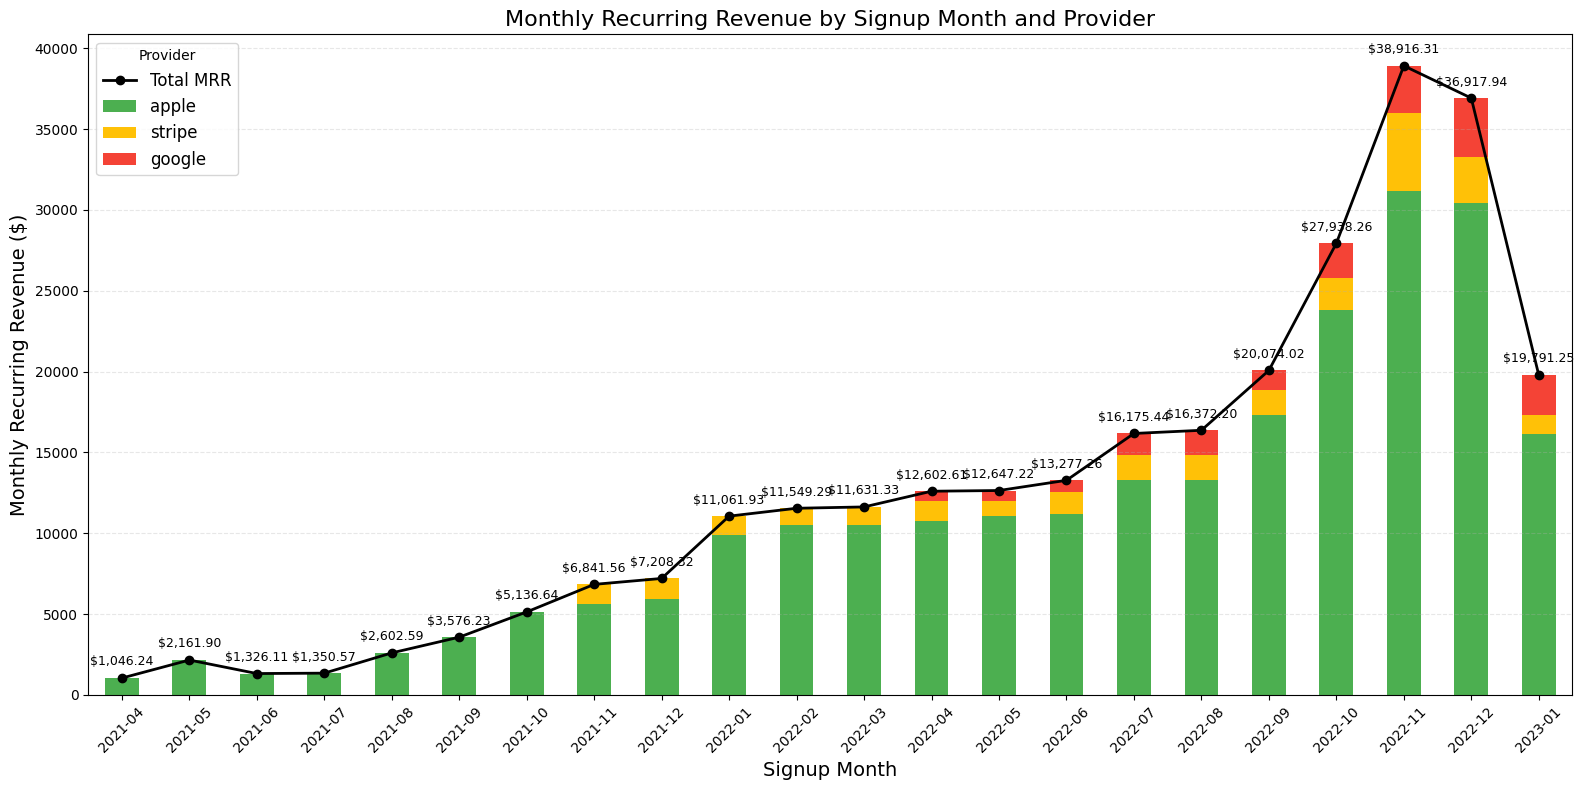

Monthly Recurring Revenue by Provider and Signup Month:
            apple   stripe   google     Total
2021-04   1046.24     0.00     0.00   1046.24
2021-05   2161.90     0.00     0.00   2161.90
2021-06   1326.11     0.00     0.00   1326.11
2021-07   1350.57     0.00     0.00   1350.57
2021-08   2602.59     0.00     0.00   2602.59
2021-09   3576.23     0.00     0.00   3576.23
2021-10   5136.64     0.00     0.00   5136.64
2021-11   5634.38  1207.18     0.00   6841.56
2021-12   5913.21  1295.11     0.00   7208.32
2022-01   9889.75  1172.18     0.00  11061.93
2022-02  10485.76  1063.53     0.00  11549.29
2022-03  10485.85  1125.73    19.75  11631.33
2022-04  10791.57  1196.38   614.66  12602.61
2022-05  11059.74   948.27   639.21  12647.22
2022-06  11198.68  1336.81   741.77  13277.26
2022-07  13287.67  1561.13  1326.64  16175.44
2022-08  13267.67  1600.69  1503.84  16372.20
2022-09  17291.34  1586.74  1195.94  20074.02
2022-10  23792.88  2017.25  2128.13  27938.26
2022-11  31172.47  4821.

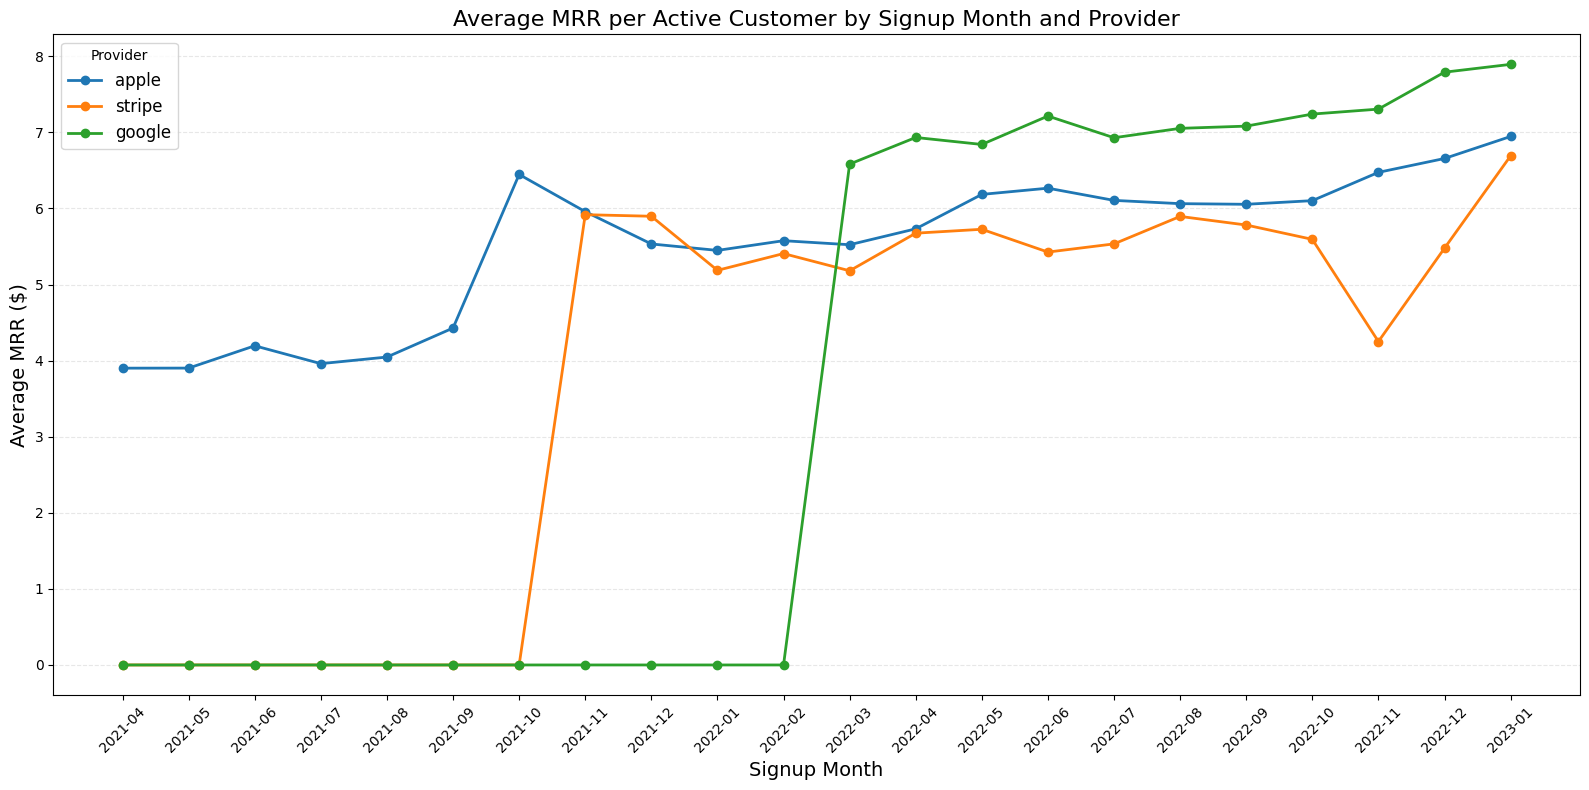

In [103]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Filter for converted accounts
df_analysis = grouped_df[grouped_df['converted'] == 1].copy()

# Extract the month part from signup_cohort
df_analysis['signup_month'] = df_analysis['signup_cohort']

# Create a list of all months in chronological order
all_months = sorted(df_analysis['signup_month'].unique())

# Create empty DataFrame to store provider data by month
provider_mrr_by_month = pd.DataFrame(index=all_months)

# Calculate MRR by signup month for each provider
for provider in df_analysis['provider'].unique():
    provider_data = df_analysis[df_analysis['provider'] == provider]
    
    # Calculate total MRR by signup month for this provider
    provider_mrr = provider_data.groupby('signup_month').apply(
        lambda x: (x['avg_current_mrr'] * x['customer_count']).sum()
    )
    provider_mrr_by_month[provider] = provider_mrr

# Fill NaN values with 0
provider_mrr_by_month = provider_mrr_by_month.fillna(0)

# Create a stacked bar chart for provider MRR by month
plt.figure(figsize=(16, 8))
ax = provider_mrr_by_month.plot(
    kind='bar', stacked=True, figsize=(16, 8),
    color=['#4CAF50', '#FFC107', '#F44336'])  # Colors for each provider

# Add total line
provider_mrr_by_month['Total'] = provider_mrr_by_month.sum(axis=1)
plt.plot(range(len(provider_mrr_by_month)), provider_mrr_by_month['Total'], 
         marker='o', color='black', linewidth=2, label='Total MRR')

plt.title('Monthly Recurring Revenue by Signup Month and Provider', fontsize=16)
plt.xlabel('Signup Month', fontsize=14)
plt.ylabel('Monthly Recurring Revenue ($)', fontsize=14)
plt.legend(title='Provider', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.3)

# Add total value labels
for i, mrr in enumerate(provider_mrr_by_month['Total']):
    if mrr > 0:
        plt.text(i, mrr + provider_mrr_by_month['Total'].max()*0.02, 
                f'${mrr:,.2f}', ha='center', fontsize=9)

plt.tight_layout()
plt.show()

# Print out the data for reference
print("Monthly Recurring Revenue by Provider and Signup Month:")
print(provider_mrr_by_month.round(2))

# Also create a chart for average MRR per customer by provider
plt.figure(figsize=(16, 8))

# Create empty DataFrame for average MRR per customer
avg_mrr_by_provider_month = pd.DataFrame(index=all_months)

# Calculate average MRR per customer by signup month for each provider
for provider in df_analysis['provider'].unique():
    provider_data = df_analysis[df_analysis['provider'] == provider]
    
    # Calculate average MRR by signup month
    active_provider_data = provider_data[provider_data['is_active'] == 1]
    monthly_avg_mrr = active_provider_data.groupby('signup_month')['avg_current_mrr'].mean()
    avg_mrr_by_provider_month[provider] = monthly_avg_mrr

# Fill NaN values with 0
avg_mrr_by_provider_month = avg_mrr_by_provider_month.fillna(0)

# Create line chart for average MRR by provider over time
for provider in df_analysis['provider'].unique():
    plt.plot(range(len(avg_mrr_by_provider_month)), 
             avg_mrr_by_provider_month[provider], 
             marker='o', linewidth=2, label=provider)

plt.title('Average MRR per Active Customer by Signup Month and Provider', fontsize=16)
plt.xlabel('Signup Month', fontsize=14)
plt.ylabel('Average MRR ($)', fontsize=14)
plt.legend(title='Provider', fontsize=12)
plt.xticks(range(len(avg_mrr_by_provider_month)), avg_mrr_by_provider_month.index, rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

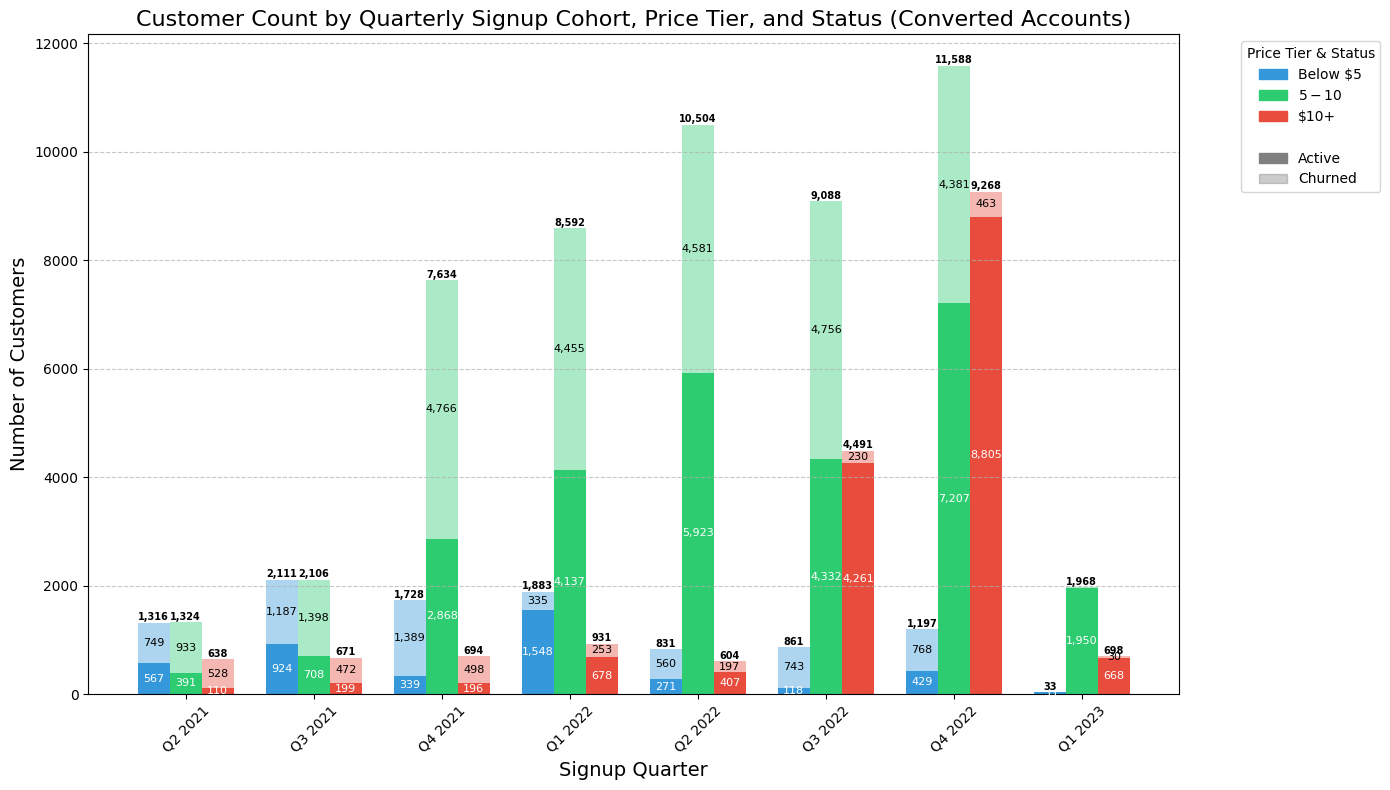

Customer counts by quarter, tier, and status:
customer_status                   Active  Churned
signup_quarter simple_price_tier                 
Q1 2022        $10+                  678      253
               $5-$10               4137     4455
               Below $5             1548      335
Q1 2023        $10+                  668       30
               $5-$10               1950       18
               Below $5               33        0
Q2 2021        $10+                  110      528
               $5-$10                391      933
               Below $5              567      749
Q2 2022        $10+                  407      197
               $5-$10               5923     4581
               Below $5              271      560
Q3 2021        $10+                  199      472
               $5-$10                708     1398
               Below $5              924     1187
Q3 2022        $10+                 4261      230
               $5-$10               4332     4756
    

In [60]:
# Analysis of customer counts by quarterly signup cohort, price tier, and active/churned status
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches

# Filter to include only converted customers
converted_df = grouped_df[grouped_df['converted'] == 1].copy()

# Create simplified price tier categories
def simplify_price_tier(tier):
    if tier is None or pd.isna(tier):
        return 'Unknown'
    # Check if the tier is below $5
    elif any(x in tier for x in ['$2.50-$5']):
        return 'Below $5'
    # Check if the tier is between $5 and $10
    elif any(x in tier for x in ['$5-$7.50', '$7.50-$10']):
        return '$5-$10'
    # Everything else is $10+
    else:
        return '$10+'

# Add the simplified price tier column
converted_df['simple_price_tier'] = converted_df['price_tier'].apply(simplify_price_tier)

# Create customer status column - only Active or Churned since all are converted
def get_status(row):
    if row['is_active'] == 1:
        return 'Active'
    else:
        return 'Churned'  # If not active, must be churned for converted accounts

converted_df['customer_status'] = converted_df.apply(get_status, axis=1)

# Convert monthly cohorts to quarterly cohorts
def get_quarter(month_str):
    date = pd.to_datetime(month_str + '-01')
    return f"Q{(date.month-1)//3+1} {date.year}"

converted_df['signup_quarter'] = converted_df['signup_cohort'].apply(get_quarter)

# Aggregate customer counts by quarter, price tier, and status
customer_counts = converted_df.groupby(['signup_quarter', 'simple_price_tier', 'customer_status'])['customer_count'].sum().reset_index()

# Filter out the 'Unknown' price tier if present
customer_counts = customer_counts[customer_counts['simple_price_tier'] != 'Unknown']

# Sort quarters chronologically 
def quarter_sort_key(q):
    parts = q.split()
    year = int(parts[1])
    quarter = int(parts[0][1])
    return year * 10 + quarter

# Create a sorted list of quarters
all_quarters = sorted(customer_counts['signup_quarter'].unique(), key=quarter_sort_key)

# Create bar chart
plt.figure(figsize=(14, 8))

# Set up the grouped bars
x = np.arange(len(all_quarters))
width = 0.25

# Colors for each price tier
colors = {
    'Below $5': '#3498db',  # Blue
    '$5-$10': '#2ecc71',    # Green
    '$10+': '#e74c3c'       # Red
}

# Status opacity/shading styles
status_styles = {
    'Active': 1.0,    # Solid
    'Churned': 0.4    # Lighter opacity
}

# Price tiers and status order
tiers = ['Below $5', '$5-$10', '$10+']
status_order = ['Active', 'Churned']

# Loop through each price tier
for i, tier in enumerate(tiers):
    # Base x position for this tier
    base_x = x + (i - 1) * width
    
    # Get data for just this tier
    tier_data = customer_counts[customer_counts['simple_price_tier'] == tier]
    
    # Create a pivot table for this tier's status breakdown
    pivot_data = pd.pivot_table(
        tier_data,
        values='customer_count',
        index='signup_quarter',
        columns='customer_status',
        fill_value=0
    )
    
    # Ensure all quarters are present
    pivot_data = pivot_data.reindex(all_quarters, fill_value=0)
    
    # Ensure all statuses are present
    for status in status_order:
        if status not in pivot_data.columns:
            pivot_data[status] = 0
    
    # Calculate bottom positions for stacking
    bottoms = np.zeros(len(all_quarters))
    
    # Create a stacked bar for each status (active on bottom, churned on top)
    for status in status_order:
        # Get heights for this status
        heights = pivot_data[status].values
        
        # Plot the bars for this tier and status
        bars = plt.bar(
            base_x, 
            heights, 
            width, 
            bottom=bottoms,
            color=colors[tier],
            alpha=status_styles[status],
            label=f'{tier} - {status}' if i == 0 else None  # Only label first tier's statuses
        )
        
        # Add data labels in the middle of each segment if large enough
        for j, bar in enumerate(bars):
            height = bar.get_height()
            if height > 20:  # Only add text if segment is tall enough
                plt.text(
                    bar.get_x() + bar.get_width()/2.,
                    bottoms[j] + height/2,
                    f'{int(height):,}',
                    ha='center',
                    va='center',
                    fontsize=8,
                    color='white' if status == 'Active' else 'black'  # Ensure text is readable
                )
        
        # Update bottoms for next status
        bottoms += heights
    
    # Add total count on top of each stacked bar with smaller font
    for j, bottom in enumerate(bottoms):
        if bottom > 0:
            plt.text(
                base_x[j],
                bottom + 8,  # Increased vertical offset for better spacing
                f'{int(bottom):,}',
                ha='center',
                va='bottom',
                fontsize=7,  # Reduced font size from 9 to 7
                fontweight='bold'
            )

# Create a better legend
legend_elements = []

# Add tier colors
for tier in tiers:
    legend_elements.append(mpatches.Patch(color=colors[tier], label=tier))

# Add a separator
legend_elements.append(plt.Line2D([0], [0], color='white', label=''))

# Add status shading
legend_elements.append(mpatches.Patch(color='gray', alpha=status_styles['Active'], label='Active'))
legend_elements.append(mpatches.Patch(color='gray', alpha=status_styles['Churned'], label='Churned'))

plt.legend(handles=legend_elements, title='Price Tier & Status',
          bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title('Customer Count by Quarterly Signup Cohort, Price Tier, and Status (Converted Accounts)', fontsize=16)
plt.xlabel('Signup Quarter', fontsize=14)
plt.ylabel('Number of Customers', fontsize=14)
plt.xticks(x, all_quarters, rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Display the data in tabular format
print("Customer counts by quarter, tier, and status:")
status_pivot = pd.pivot_table(
    customer_counts,
    values='customer_count',
    index=['signup_quarter', 'simple_price_tier'],
    columns='customer_status',
    fill_value=0
).astype(int)

print(status_pivot)

# Calculate active rate for each tier and quarter
status_percent = pd.pivot_table(
    customer_counts,
    values='customer_count',
    index=['signup_quarter', 'simple_price_tier'],
    columns='customer_status',
    aggfunc='sum'
)

status_percent['Total'] = status_percent.sum(axis=1)
status_percent['Active_Rate'] = (status_percent['Active'] / status_percent['Total']) * 100

print("\nActive rate (%) by quarter and price tier:")
print(status_percent['Active_Rate'].unstack().round(1))

### Takeaways on customer retention
- There is heavy churn in first three months 
- There seems to be a point at which churn improved going into 2022-01
    - This could be the start of longer term 1 year contract, would need to see if rentention dips more the next month 
    - Could also be something else aboutt he product that changed
- Higher price tiers of average payment size seem to experience higher retention for longer 
    - Claim to be made to:
        1. Upsell customers harder or remove lower tiers
        2. Drive them into the tier which is seen as beneficial to customer
        3. Raise prices 
        4. Advertise to these possible higher tier customers (seems like they started to in )

Using table: grouped_metrics_subscription_data_2023_01

Customer Activity and Expansion by Signup Cohort:
   signup_cohort  total_customers  active_customers  active_rate  \
0        2021-04              759               253    33.333333   
1        2021-05             1587               502    31.632010   
2        2021-06              932               313    33.583691   
3        2021-07              959               351    36.600626   
4        2021-08             1642               647    39.403167   
5        2021-09             2287               833    36.423262   
6        2021-10             2645               850    32.136106   
7        2021-11             3602              1217    33.786785   
8        2021-12             3809              1336    35.074823   
9        2022-01             3927              2092    53.272218   
10       2022-02             3704              2114    57.073434   
11       2022-03             3775              2157    57.139073   
12       2

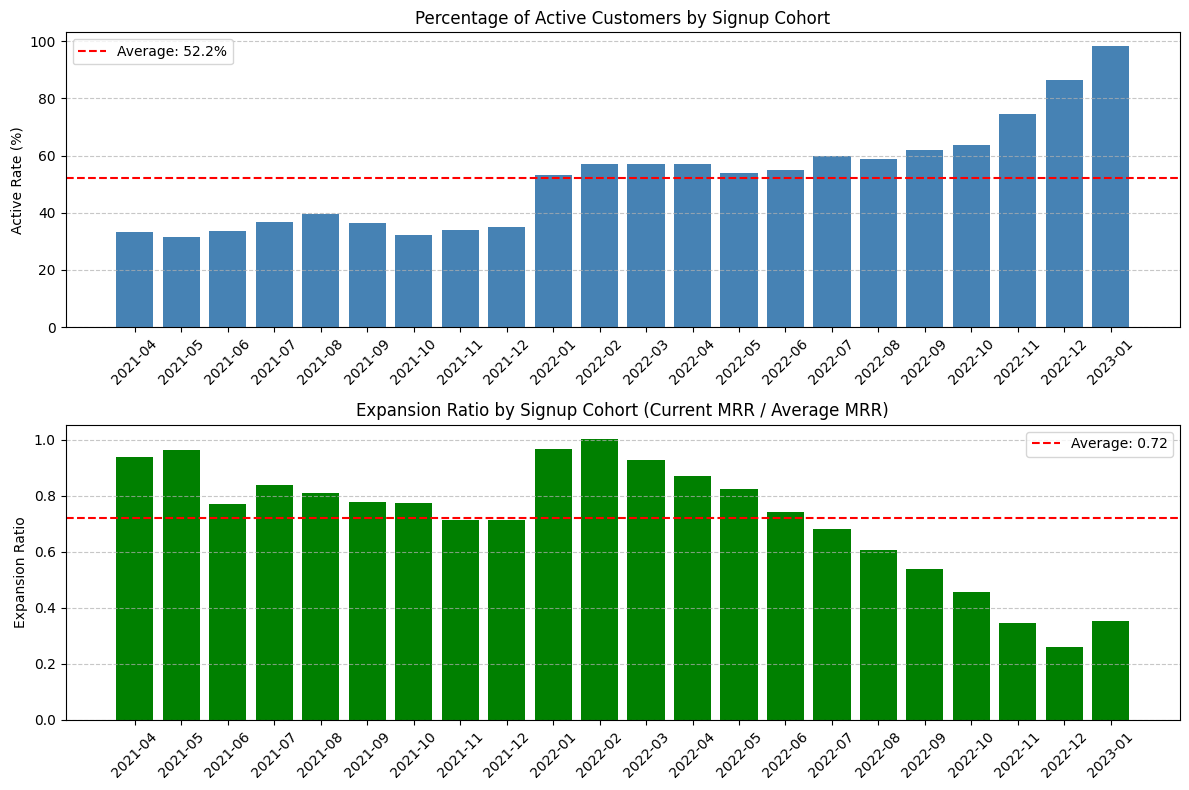

In [61]:
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3

# Connect to the database
db_path = "Subscriptions.db"
conn = sqlite3.connect(db_path)

# Find and use the most recent metrics table
cursor = conn.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table' AND name LIKE 'grouped_metrics_subscription_data_%';")
tables = cursor.fetchall()
latest_metrics_table = sorted([table[0] for table in tables])[-1]
print(f"Using table: {latest_metrics_table}")

# Get data for converted accounts only
query = f"""
SELECT signup_cohort, 
       SUM(customer_count) as total_customers,
       SUM(CASE WHEN is_active = 1 THEN customer_count ELSE 0 END) as active_customers,
       SUM(CASE WHEN is_active = 1 THEN customer_count * avg_current_mrr ELSE 0 END) / 
           SUM(CASE WHEN is_active = 1 THEN customer_count ELSE 0 END) as active_current_mrr,
       SUM(CASE WHEN is_active = 1 THEN customer_count * avg_of_avg_monthly_payment ELSE 0 END) / 
           SUM(CASE WHEN is_active = 1 THEN customer_count ELSE 0 END) as active_avg_mrr
FROM {latest_metrics_table}
WHERE converted = 1
GROUP BY signup_cohort
ORDER BY signup_cohort
"""

cohort_data = pd.read_sql_query(query, conn)
conn.close()

# Calculate key metrics
cohort_data['active_rate'] = cohort_data['active_customers'] / cohort_data['total_customers'] * 100
cohort_data['expansion_ratio'] = cohort_data['active_current_mrr'] / cohort_data['active_avg_mrr']

# Display results
print("\nCustomer Activity and Expansion by Signup Cohort:")
print(cohort_data[['signup_cohort', 'total_customers', 'active_customers', 'active_rate', 'expansion_ratio']])

# Create visualization
plt.figure(figsize=(12, 8))

# Plot 1: Active customer rate by cohort
ax1 = plt.subplot(2, 1, 1)
plt.bar(cohort_data['signup_cohort'], cohort_data['active_rate'], color='steelblue')
plt.axhline(y=cohort_data['active_rate'].mean(), color='red', linestyle='--', 
           label=f'Average: {cohort_data["active_rate"].mean():.1f}%')
plt.title('Percentage of Active Customers by Signup Cohort')
plt.ylabel('Active Rate (%)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Plot 2: Expansion ratio by cohort
ax2 = plt.subplot(2, 1, 2)
plt.bar(cohort_data['signup_cohort'], cohort_data['expansion_ratio'], color='green')
plt.axhline(y=cohort_data['expansion_ratio'].mean(), color='red', linestyle='--',
           label=f'Average: {cohort_data["expansion_ratio"].mean():.2f}')
plt.title('Expansion Ratio by Signup Cohort (Current MRR / Average MRR)')
plt.ylabel('Expansion Ratio')
plt.xticks(rotation=45)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
#plt.savefig('cohort_expansion_analysis.png', bbox_inches='tight')
# ', dpi=300)
plt.show()

In [62]:
df

,oid,provider,total_charges,signup_date,is_canceled,is_active,is_delinquent,conversion_date,cancellation_date,current_mrr,...,converted,payment_periods,avg_monthly_payment,expansion_ratio,has_expanded,price_tier,conversion_speed,conversion_speed_category,conversion_cohort,signup_cohort
0,273624174263463,apple,10.94,2021-04-20 00:00:00,1,0,0,2021-04-20 00:00:00,2021-05-20 00:00:00,0.00,...,1,1.0,10.940000,0.000000,0,$10-$12.50,0.0,None,2021-04,2021-04
1,532534633483904,apple,10.92,2021-04-20 00:00:00,1,0,0,2021-04-20 00:00:00,2021-06-20 00:00:00,0.00,...,1,2.0,5.460000,0.000000,0,$5-$7.50,0.0,None,2021-04,2021-04
2,623527156674739,apple,0.00,2021-04-20 00:00:00,0,0,0,None,None,0.00,...,0,NaN,NaN,NaN,0,None,NaN,None,None,2021-04
3,441616357320658,apple,90.30,2021-04-20 00:00:00,0,1,0,2021-04-27 00:00:00,None,3.47,...,1,21.0,4.300000,0.806977,0,$2.50-$5,7.0,1-7 days,2021-04,2021-04
4,189644194376891,apple,79.98,2021-04-20 00:00:00,0,1,0,2021-05-04 00:00:00,None,3.33,...,1,21.0,3.808571,0.874344,0,$2.50-$5,14.0,8-14 days,2021-05,2021-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134605,cus_NB35AXFFLFDCQN,stripe,0.00,2023-01-16 00:00:00,0,0,0,None,None,0.00,...,0,NaN,NaN,NaN,0,None,NaN,None,None,2023-01
134606,cus_NBFU1fiKQmfrD7,stripe,0.00,2023-01-16 00:00:00,0,0,0,None,None,0.00,...,0,NaN,NaN,NaN,0,None,NaN,None,None,2023-01
134607,cus_NBJP0fuajs4kMo,stripe,7.99,2023-01-16 00:00:00,0,1,0,2023-01-16 00:00:00,None,7.99,...,1,1.0,7.990000,1.000000,0,$7.50-$10,0.0,None,2023-01,2023-01
134608,cus_NBH1IkjtW4wAYF,stripe,0.00,2023-01-16 00:00:00,0,0,0,None,None,0.00,...,0,NaN,NaN,NaN,0,None,NaN,None,None,2023-01


In [79]:
# Create mask for low expansion ratio
low_expansion_mask = (df['expansion_ratio'] < 0.90) & (df['expansion_ratio'] > 0)

#low_expansion_mask = df
# Filter and display relevant columns
columns_to_show = ['oid', 'provider', 'expansion_ratio', 'current_mrr', 'avg_monthly_payment', 'payment_periods','total_charges', 
                  'is_active', 'is_canceled', 'conversion_date']

low_expansion_df = df[low_expansion_mask][columns_to_show].sort_values('expansion_ratio')

# Display results with context
print(f"Customers with expansion ratio < 0.90: {low_expansion_mask.sum():,} out of {len(df):,} total customers")
print(f"Percentage: {(low_expansion_mask.sum()/len(df))*100:.2f}%")
print("\nDetailed view of customers with low expansion ratio:")
print(low_expansion_df.head(10))

# Show summary statistics for this segment
print("\nSummary statistics for low expansion customers:")
print(low_expansion_df[['expansion_ratio', 'current_mrr', 'total_charges']].describe())

Customers with expansion ratio < 0.90: 25,151 out of 134,610 total customers
Percentage: 18.68%

Detailed view of customers with low expansion ratio:
                       oid provider  expansion_ratio  current_mrr  \
24970   cus_KmfqcVq6WE4gmw   stripe         0.043486         5.00   
80632   cus_MDfxfIGFCYYqyf   stripe         0.066406         4.58   
116812  cus_MsU18hrfTQpODq   stripe         0.074649         5.00   
129892     469588193309377    apple         0.083189         2.88   
130894     532575821394059    apple         0.083213         2.88   
127524     504596502665033    apple         0.083213         2.89   
116090     483569702844825    apple         0.083217         5.38   
122297     637464713162041    apple         0.083218         5.43   
124590     217672504540283    apple         0.083224         3.16   
127279     252622244147100    apple         0.083229         4.66   

        avg_monthly_payment  payment_periods  total_charges  is_active  \
24970           

In [84]:
# Filter the data as specified
active_customers = df[(df['converted'] == 1) & 
                      (df['is_canceled'] == 0) & 
                      (df['is_active'] == 1) & 
                      (df['expansion_ratio'] > 0) & 
                      (df['total_charges'] > 0)]

# Create a pivot table with average expansion ratio by signup cohort
pivot_df = pd.pivot_table(active_customers, 
                          values='expansion_ratio',
                          index='signup_cohort',
                          aggfunc=['mean', 'median', 'count'])

# Clean up column names
pivot_df.columns = ['avg_expansion_ratio', 'median_expansion_ratio', 'customer_count']
pivot_df = pivot_df.reset_index()

# Sort by signup cohort
pivot_df = pivot_df.sort_values('signup_cohort')

# Format for better readability
pivot_df['avg_expansion_ratio'] = pivot_df['avg_expansion_ratio'].round(3)
pivot_df['median_expansion_ratio'] = pivot_df['median_expansion_ratio'].round(3)

# Display the pivot table
print("Average Expansion Ratio by Signup Cohort:")
print(pivot_df)

# If you want to save this to a CSV
# pivot_df.to_csv('expansion_ratio_by_cohort.csv', index=False)

Average Expansion Ratio by Signup Cohort:
   signup_cohort  avg_expansion_ratio  median_expansion_ratio  customer_count
0        2021-04                0.926                   0.874             253
1        2021-05                0.974                   0.874             502
2        2021-06                0.774                   0.633             313
3        2021-07                0.852                   0.749             351
4        2021-08                0.896                   0.708             647
5        2021-09                1.550                   0.666             829
6        2021-10                0.795                   0.625             849
7        2021-11                1.215                   0.583            1212
8        2021-12                1.110                   0.583            1332
9        2022-01                3.935                   1.000            2047
10       2022-02               16.246                   0.918            2042
11       2022-03      

In [91]:
# Filter the data as specified
active_customers = df[(df['converted'] == 1) & 
                      (df['is_canceled'] == 0) & 
                      (df['is_active'] == 1)]

# Group by signup cohort
cohort_metrics = active_customers.groupby('signup_cohort').agg({
    'customer_count': 'sum',
    'avg_current_mrr': lambda x: np.average(x, weights=active_customers.loc[x.index, 'customer_count']),
    'avg_of_avg_monthly_payment': lambda x: np.average(x, weights=active_customers.loc[x.index, 'customer_count']),
    'total_charges': 'sum'
}).reset_index()

# Calculate expansion ratio for each cohort
cohort_metrics['calculated_expansion_ratio'] = cohort_metrics['avg_current_mrr'] / cohort_metrics['avg_of_avg_monthly_payment']

# Sort by signup cohort
cohort_metrics = cohort_metrics.sort_values('signup_cohort')

# Format for better readability
cohort_metrics['calculated_expansion_ratio'] = cohort_metrics['calculated_expansion_ratio'].round(3)
cohort_metrics['avg_current_mrr'] = cohort_metrics['avg_current_mrr'].round(2)
cohort_metrics['avg_of_avg_monthly_payment'] = cohort_metrics['avg_of_avg_monthly_payment'].round(2)

# Display the results
print("Calculated Expansion Ratio by Signup Cohort:")
print(cohort_metrics[['signup_cohort', 'calculated_expansion_ratio', 'avg_current_mrr', 
                      'avg_of_avg_monthly_payment', 'customer_count', 'total_charges']])

# Calculate overall weighted average
overall_expansion = (
    cohort_metrics['avg_current_mrr'].sum() / 
    cohort_metrics['avg_of_avg_monthly_payment'].sum()
)
print(f"\nOverall expansion ratio: {overall_expansion:.3f}")

KeyError: "Column(s) ['avg_current_mrr', 'avg_of_avg_monthly_payment', 'customer_count'] do not exist"

In [93]:
# Filter the data as specified
active_customers = df[(df['converted'] == 1) & 
                     (df['is_canceled'] == 0) & 
                     (df['is_active'] == 1)]

# Group by signup cohort
# Since there's no customer_count, we'll need to count rows by cohort
cohort_metrics = active_customers.groupby('signup_cohort').agg({
    'oid': 'count',  # Count unique customers
    'current_mrr': 'mean',  # Average current MRR per cohort
    'avg_monthly_payment': 'mean',  # Average monthly payment per cohort
    'total_charges': 'sum'  # Total charges per cohort
}).reset_index()

# Rename columns for clarity
cohort_metrics = cohort_metrics.rename(columns={'oid': 'customer_count'})

# Calculate expansion ratio for each cohort
cohort_metrics['calculated_expansion_ratio'] = cohort_metrics['current_mrr'] / cohort_metrics['avg_monthly_payment']

# Sort by signup cohort
cohort_metrics = cohort_metrics.sort_values('signup_cohort')

# Format for better readability
cohort_metrics['calculated_expansion_ratio'] = cohort_metrics['calculated_expansion_ratio'].round(3)
cohort_metrics['current_mrr'] = cohort_metrics['current_mrr'].round(2)
cohort_metrics['avg_monthly_payment'] = cohort_metrics['avg_monthly_payment'].round(2)

# Display the results
print("Calculated Expansion Ratio by Signup Cohort:")
print(cohort_metrics[['signup_cohort', 'calculated_expansion_ratio', 'current_mrr', 
                     'avg_monthly_payment', 'customer_count', 'total_charges']])

# Calculate overall weighted avg expansion ratio (weighted by customer count)
overall_expansion = (
    (cohort_metrics['current_mrr'] * cohort_metrics['customer_count']).sum() / 
    (cohort_metrics['avg_monthly_payment'] * cohort_metrics['customer_count']).sum()
)

print(f"\nOverall expansion ratio: {overall_expansion:.3f}")

# Compare with simple mean of expansion_ratio
print(f"Average of individual expansion ratios: {active_customers['expansion_ratio'].mean():.3f}")

Calculated Expansion Ratio by Signup Cohort:
   signup_cohort  calculated_expansion_ratio  current_mrr  \
0        2021-04                       0.940         4.14   
1        2021-05                       0.963         4.31   
2        2021-06                       0.769         4.24   
3        2021-07                       0.837         3.85   
4        2021-08                       0.809         4.02   
5        2021-09                       0.777         4.29   
6        2021-10                       0.773         6.04   
7        2021-11                       0.712         5.62   
8        2021-12                       0.713         5.40   
9        2022-01                       0.966         5.29   
10       2022-02                       1.004         5.46   
11       2022-03                       0.926         5.39   
12       2022-04                       0.871         5.65   
13       2022-05                       0.825         5.92   
14       2022-06                       0

Payment Analysis by Signup Cohort:
   signup_cohort  avg_monthly_payment  current_mrr  payment_periods  \
0        2021-04                 4.40         4.14             21.0   
1        2021-05                 4.47         4.31             20.4   
2        2021-06                 5.51         4.24             19.4   
3        2021-07                 4.60         3.85             18.2   
4        2021-08                 4.97         4.02             17.2   
5        2021-09                 5.53         4.29             16.3   
6        2021-10                 7.81         6.04             15.3   
7        2021-11                 7.90         5.62             13.9   
8        2021-12                 7.57         5.40             13.1   
9        2022-01                 5.47         5.29             12.2   
10       2022-02                 5.44         5.46             11.3   
11       2022-03                 5.82         5.39             10.2   
12       2022-04                 6.48     

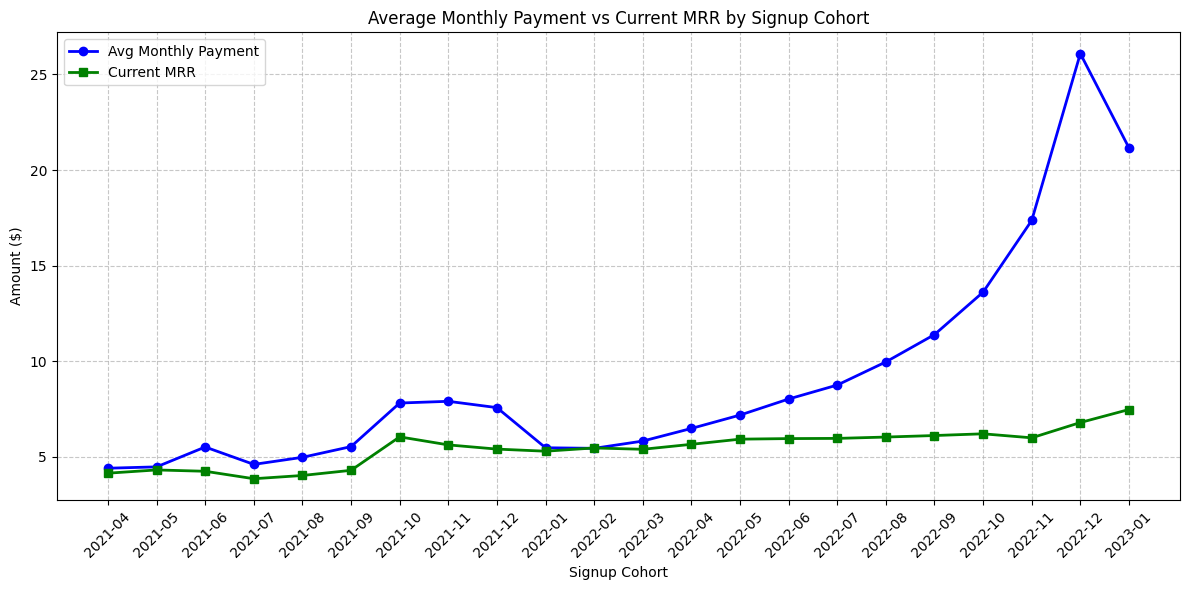


Ratio of Avg Monthly Payment to Current MRR:
   signup_cohort  payment_to_mrr_ratio  payment_periods
0        2021-04              1.062802             21.0
1        2021-05              1.037123             20.4
2        2021-06              1.299528             19.4
3        2021-07              1.194805             18.2
4        2021-08              1.236318             17.2
5        2021-09              1.289044             16.3
6        2021-10              1.293046             15.3
7        2021-11              1.405694             13.9
8        2021-12              1.401852             13.1
9        2022-01              1.034026             12.2
10       2022-02              0.996337             11.3
11       2022-03              1.079777             10.2
12       2022-04              1.146903              9.3
13       2022-05              1.212838              8.2
14       2022-06              1.347899              7.2
15       2022-07              1.468121              6.2
16

In [94]:
# Group data by signup cohort and analyze payment patterns
payment_analysis = df[(df['converted'] == 1) & 
                     (df['is_active'] == 1)].groupby('signup_cohort').agg({
    'oid': 'count',
    'current_mrr': 'mean',
    'avg_monthly_payment': 'mean',
    'payment_periods': 'mean',
    'total_charges': 'mean'
}).reset_index()

# Sort by signup cohort
payment_analysis = payment_analysis.sort_values('signup_cohort')

# Format for better readability
payment_analysis['current_mrr'] = payment_analysis['current_mrr'].round(2)
payment_analysis['avg_monthly_payment'] = payment_analysis['avg_monthly_payment'].round(2)
payment_analysis['payment_periods'] = payment_analysis['payment_periods'].round(1)
payment_analysis['total_charges'] = payment_analysis['total_charges'].round(2)

# Display the results
print("Payment Analysis by Signup Cohort:")
print(payment_analysis[['signup_cohort', 'avg_monthly_payment', 'current_mrr', 
                        'payment_periods', 'total_charges', 'oid']])

# Create a visualization to see the trend
plt.figure(figsize=(12, 6))
plt.plot(payment_analysis['signup_cohort'], payment_analysis['avg_monthly_payment'], 'o-', 
         label='Avg Monthly Payment', linewidth=2, color='blue')
plt.plot(payment_analysis['signup_cohort'], payment_analysis['current_mrr'], 's-', 
         label='Current MRR', linewidth=2, color='green')
plt.title('Average Monthly Payment vs Current MRR by Signup Cohort')
plt.xlabel('Signup Cohort')
plt.ylabel('Amount ($)')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

# Calculate the ratio between them
payment_analysis['payment_to_mrr_ratio'] = payment_analysis['avg_monthly_payment'] / payment_analysis['current_mrr']
print("\nRatio of Avg Monthly Payment to Current MRR:")
print(payment_analysis[['signup_cohort', 'payment_to_mrr_ratio', 'payment_periods']])

Current MRR as Percentage of Total Charges by Signup Cohort:
   signup_cohort  mrr_percentage  avg_mrr_per_customer  \
0        2021-04            4.48                  4.14   
1        2021-05            4.71                  4.31   
2        2021-06            3.97                  4.24   
3        2021-07            4.60                  3.85   
4        2021-08            4.71                  4.02   
5        2021-09            4.78                  4.29   
6        2021-10            5.06                  6.04   
7        2021-11            5.22                  5.62   
8        2021-12            5.56                  5.40   
9        2022-01            7.95                  5.29   
10       2022-02            8.94                  5.46   
11       2022-03            9.16                  5.39   
12       2022-04            9.42                  5.65   
13       2022-05           10.05                  5.92   
14       2022-06           10.42                  5.95   
15       20

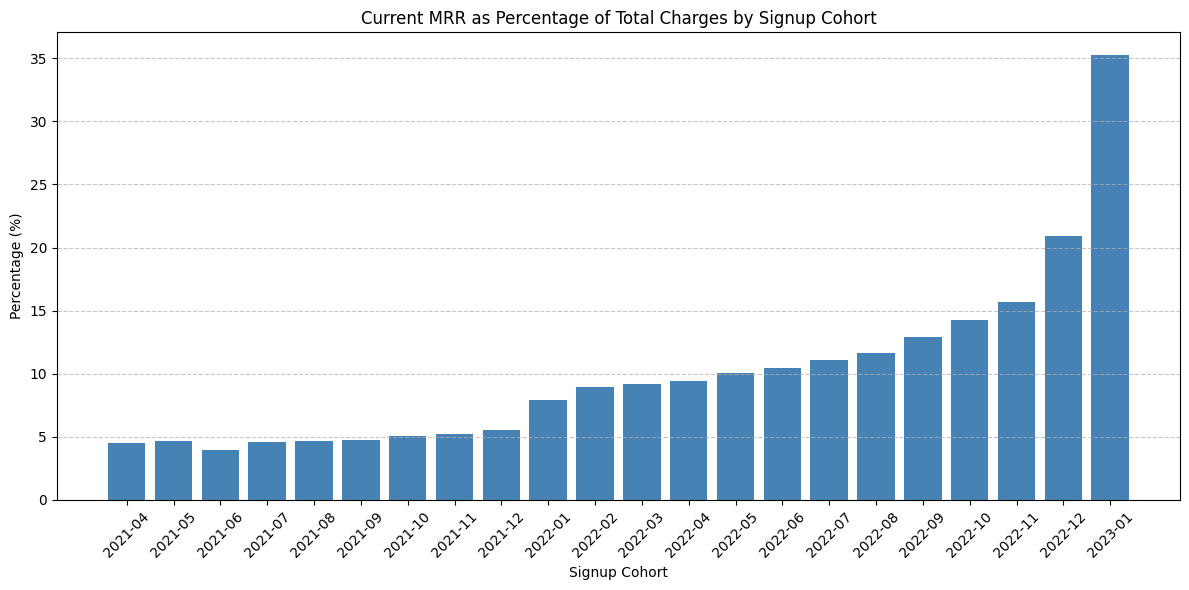

In [95]:
# Filter for relevant customers
active_converted = df[(df['converted'] == 1) & (df['is_active'] == 1)]

# Group by signup cohort
cohort_analysis = active_converted.groupby('signup_cohort').agg({
    'current_mrr': 'sum',
    'total_charges': 'sum',
    'oid': 'count'
}).reset_index()

# Calculate current MRR as percentage of total charges
cohort_analysis['mrr_percentage'] = (cohort_analysis['current_mrr'] / cohort_analysis['total_charges']) * 100

# Calculate average MRR and total charges per customer
cohort_analysis['avg_mrr_per_customer'] = cohort_analysis['current_mrr'] / cohort_analysis['oid']
cohort_analysis['avg_total_charges_per_customer'] = cohort_analysis['total_charges'] / cohort_analysis['oid']

# Sort by signup cohort
cohort_analysis = cohort_analysis.sort_values('signup_cohort')

# Format for better readability
cohort_analysis['mrr_percentage'] = cohort_analysis['mrr_percentage'].round(2)
cohort_analysis['avg_mrr_per_customer'] = cohort_analysis['avg_mrr_per_customer'].round(2)
cohort_analysis['avg_total_charges_per_customer'] = cohort_analysis['avg_total_charges_per_customer'].round(2)

# Display the results
print("Current MRR as Percentage of Total Charges by Signup Cohort:")
print(cohort_analysis[['signup_cohort', 'mrr_percentage', 'avg_mrr_per_customer', 
                      'avg_total_charges_per_customer', 'oid']])

# Create a visualization to see the trend
plt.figure(figsize=(12, 6))
plt.bar(cohort_analysis['signup_cohort'], cohort_analysis['mrr_percentage'], color='steelblue')
plt.title('Current MRR as Percentage of Total Charges by Signup Cohort')
plt.xlabel('Signup Cohort')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Current MRR as Percentage of Average Monthly Payment by Signup Cohort:
   signup_cohort  mrr_to_monthly_percentage  current_mrr  avg_monthly_payment  \
0        2021-04                      93.98         4.14                 4.40   
1        2021-05                      96.35         4.31                 4.47   
2        2021-06                      76.90         4.24                 5.51   
3        2021-07                      83.71         3.85                 4.60   
4        2021-08                      80.89         4.02                 4.97   
5        2021-09                      77.67         4.29                 5.53   
6        2021-10                      77.35         6.04                 7.81   
7        2021-11                      71.18         5.62                 7.90   
8        2021-12                      71.29         5.40                 7.57   
9        2022-01                      96.61         5.29                 5.47   
10       2022-02                     1

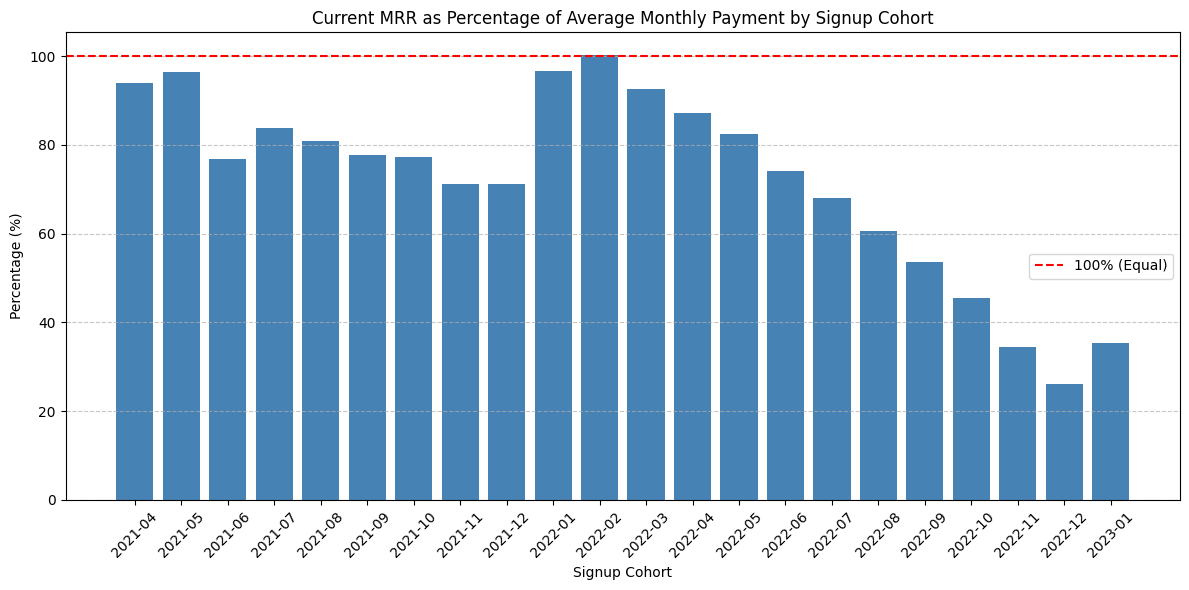

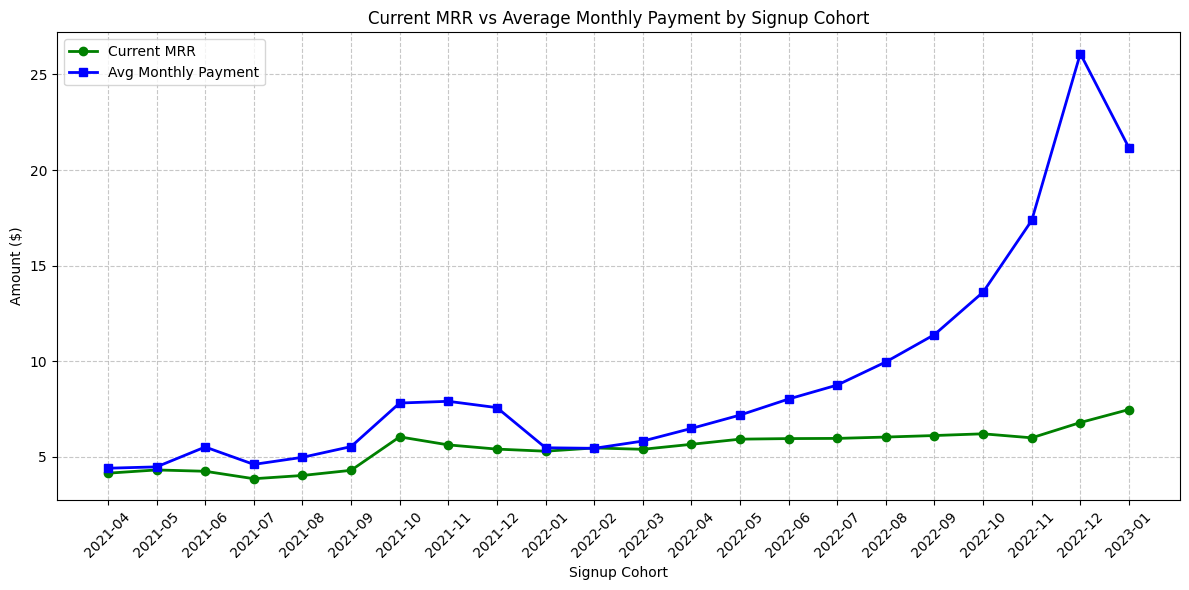

In [96]:
# Filter for relevant customers
active_converted = df[(df['converted'] == 1) & (df['is_active'] == 1)]

# Group by signup cohort
cohort_analysis = active_converted.groupby('signup_cohort').agg({
    'current_mrr': 'mean',
    'avg_monthly_payment': 'mean',
    'oid': 'count',
    'payment_periods': 'mean'
}).reset_index()

# Calculate current MRR as percentage of avg monthly payment
cohort_analysis['mrr_to_monthly_percentage'] = (cohort_analysis['current_mrr'] / cohort_analysis['avg_monthly_payment']) * 100

# Sort by signup cohort
cohort_analysis = cohort_analysis.sort_values('signup_cohort')

# Format for better readability
cohort_analysis['mrr_to_monthly_percentage'] = cohort_analysis['mrr_to_monthly_percentage'].round(2)
cohort_analysis['current_mrr'] = cohort_analysis['current_mrr'].round(2)
cohort_analysis['avg_monthly_payment'] = cohort_analysis['avg_monthly_payment'].round(2)
cohort_analysis['payment_periods'] = cohort_analysis['payment_periods'].round(1)

# Display the results
print("Current MRR as Percentage of Average Monthly Payment by Signup Cohort:")
print(cohort_analysis[['signup_cohort', 'mrr_to_monthly_percentage', 'current_mrr', 
                      'avg_monthly_payment', 'payment_periods', 'oid']])

# Create a visualization to see the trend
plt.figure(figsize=(12, 6))
plt.bar(cohort_analysis['signup_cohort'], cohort_analysis['mrr_to_monthly_percentage'], color='steelblue')
plt.axhline(y=100, color='red', linestyle='--', label='100% (Equal)')
plt.title('Current MRR as Percentage of Average Monthly Payment by Signup Cohort')
plt.xlabel('Signup Cohort')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

# Also plot both values to see the absolute difference
plt.figure(figsize=(12, 6))
plt.plot(cohort_analysis['signup_cohort'], cohort_analysis['current_mrr'], 'o-', 
         label='Current MRR', linewidth=2, color='green')
plt.plot(cohort_analysis['signup_cohort'], cohort_analysis['avg_monthly_payment'], 's-', 
         label='Avg Monthly Payment', linewidth=2, color='blue')
plt.title('Current MRR vs Average Monthly Payment by Signup Cohort')
plt.xlabel('Signup Cohort')
plt.ylabel('Amount ($)')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

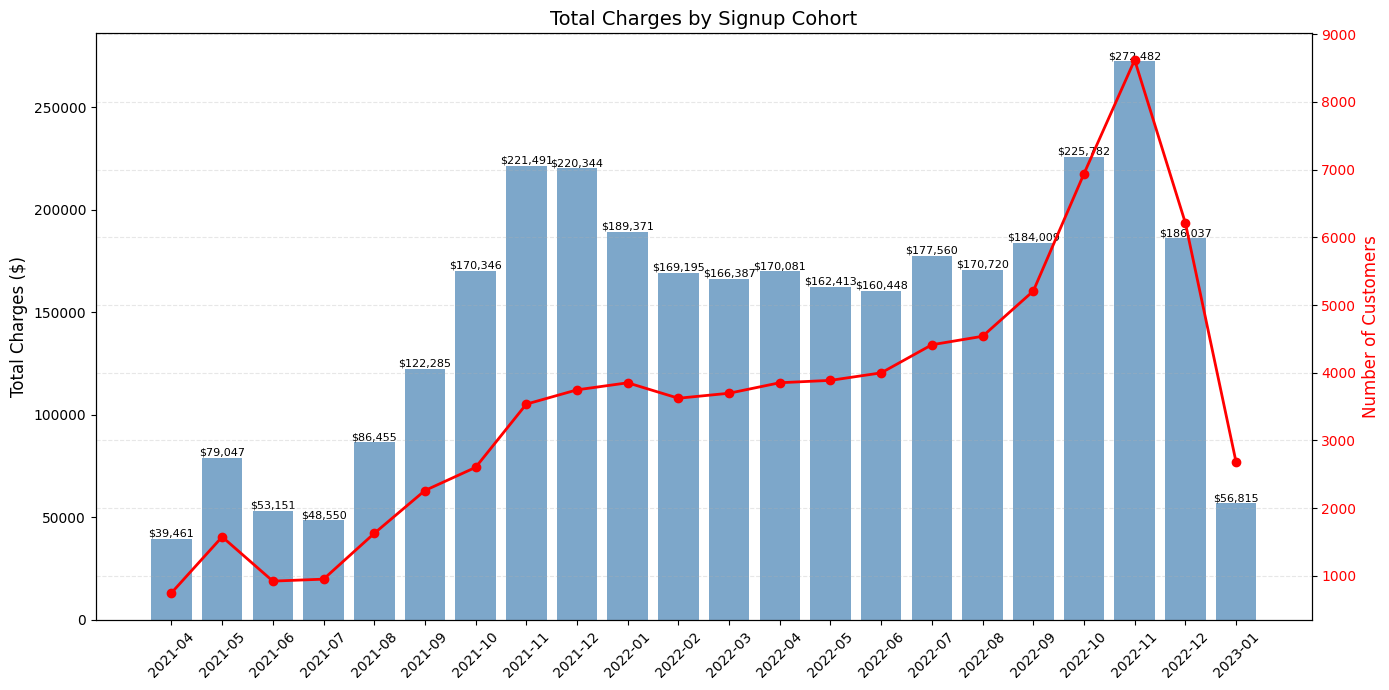

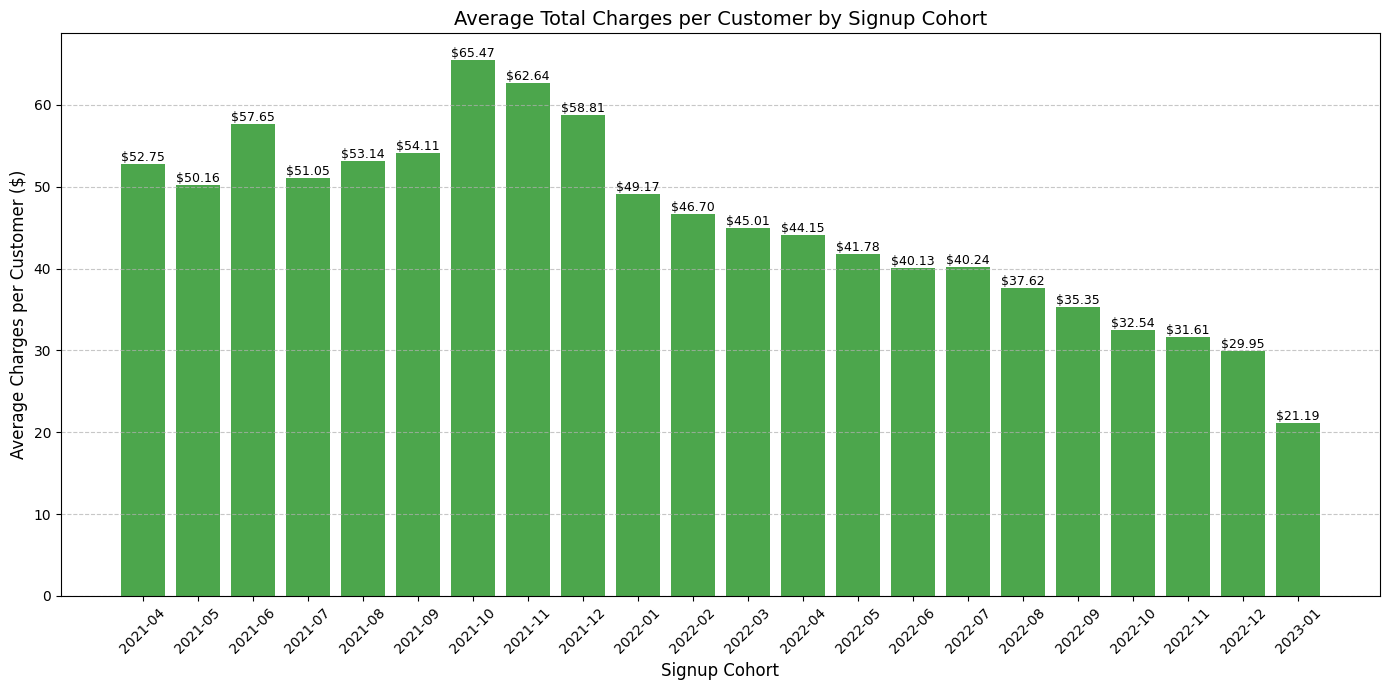

Total Charges by Signup Cohort:
   signup_cohort  total_charges  avg_charges_per_customer   oid
0        2021-04       39460.54                     52.75   748
1        2021-05       79047.38                     50.16  1576
2        2021-06       53151.06                     57.65   922
3        2021-07       48550.30                     51.05   951
4        2021-08       86455.02                     53.14  1627
5        2021-09      122285.16                     54.11  2260
6        2021-10      170346.22                     65.47  2602
7        2021-11      221490.70                     62.64  3536
8        2021-12      220343.67                     58.81  3747
9        2022-01      189370.79                     49.17  3851
10       2022-02      169194.53                     46.70  3623
11       2022-03      166387.06                     45.01  3697
12       2022-04      170081.26                     44.15  3852
13       2022-05      162412.57                     41.78  3887
14      

In [98]:
# Filter for relevant customers
active_converted = df[(df['converted'] == 1) & (df['total_charges'] > 0)]

# Group by signup cohort to get total charges
total_charges_by_cohort = active_converted.groupby('signup_cohort').agg({
    'total_charges': 'sum',
    'oid': 'count'
}).reset_index()

# Calculate average charges per customer in each cohort
total_charges_by_cohort['avg_charges_per_customer'] = total_charges_by_cohort['total_charges'] / total_charges_by_cohort['oid']

# Sort by signup cohort
total_charges_by_cohort = total_charges_by_cohort.sort_values('signup_cohort')

# Format for readability
total_charges_by_cohort['avg_charges_per_customer'] = total_charges_by_cohort['avg_charges_per_customer'].round(2)

# Create a visualization of total charges by cohort
plt.figure(figsize=(14, 7))
ax1 = plt.subplot(111)

# Plot total charges
bars = ax1.bar(total_charges_by_cohort['signup_cohort'], total_charges_by_cohort['total_charges'], 
        color='steelblue', alpha=0.7)
ax1.set_ylabel('Total Charges ($)', fontsize=12)
ax1.set_title('Total Charges by Signup Cohort', fontsize=14)
ax1.tick_params(axis='x', rotation=45)

# Add a second y-axis for customer count
ax2 = ax1.twinx()
ax2.plot(total_charges_by_cohort['signup_cohort'], total_charges_by_cohort['oid'], 'o-', 
        color='red', linewidth=2, label='Customer Count')
ax2.set_ylabel('Number of Customers', fontsize=12, color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'${height:,.0f}',
            ha='center', va='bottom', rotation=0, fontsize=8)

plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# Create a second visualization for average charges per customer
plt.figure(figsize=(14, 7))
bars = plt.bar(total_charges_by_cohort['signup_cohort'], total_charges_by_cohort['avg_charges_per_customer'], 
        color='green', alpha=0.7)
plt.title('Average Total Charges per Customer by Signup Cohort', fontsize=14)
plt.xlabel('Signup Cohort', fontsize=12)
plt.ylabel('Average Charges per Customer ($)', fontsize=12)
plt.xticks(rotation=45)

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
            f'${height:.2f}',
            ha='center', va='bottom', rotation=0, fontsize=9)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Print the data
print("Total Charges by Signup Cohort:")
print(total_charges_by_cohort[['signup_cohort', 'total_charges', 'avg_charges_per_customer', 'oid']])

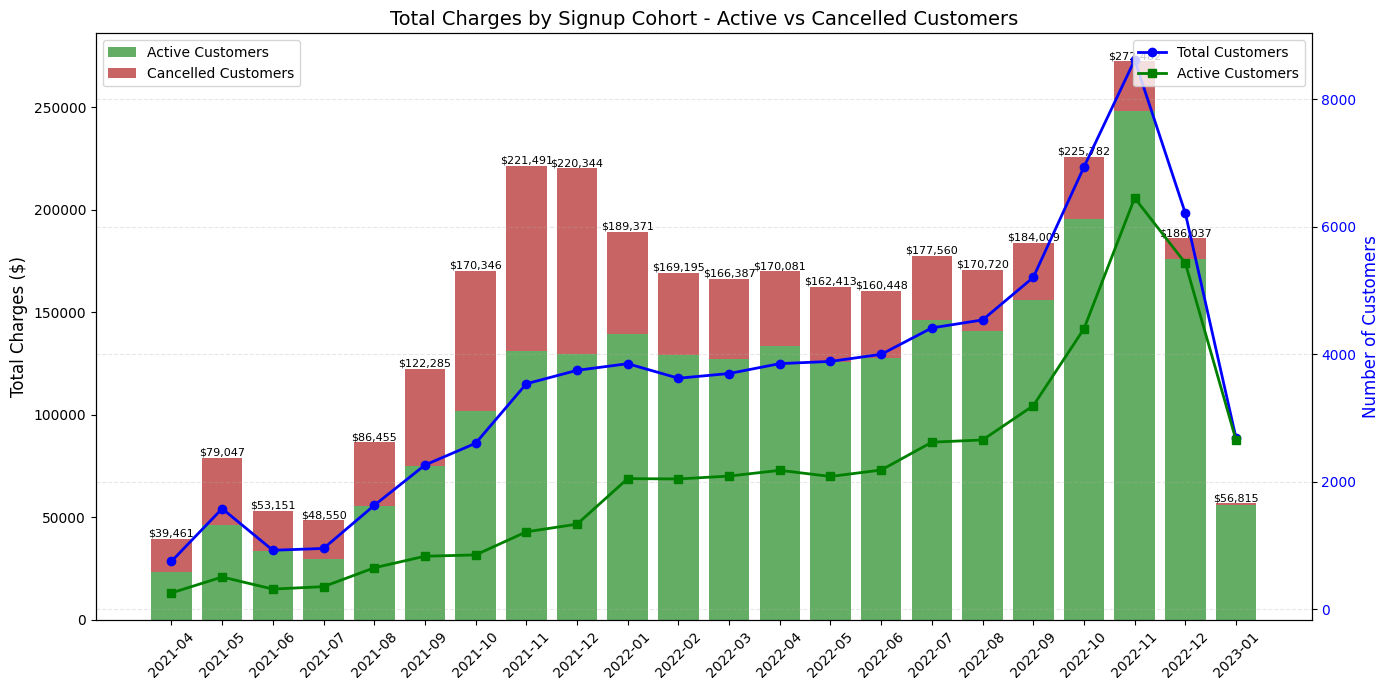

Total Charges by Signup Cohort (Active vs Cancelled):
   signup_cohort  total_charges  total_charges_active  \
0        2021-04       39460.54              23328.82   
1        2021-05       79047.38              45899.59   
2        2021-06       53151.06              33404.33   
3        2021-07       48550.30              29340.95   
4        2021-08       86455.02              55226.57   
5        2021-09      122285.16              74829.13   
6        2021-10      170346.22             101548.96   
7        2021-11      221490.70             131122.17   
8        2021-12      220343.67             129663.85   
9        2022-01      189370.79             139169.82   
10       2022-02      169194.53             129166.49   
11       2022-03      166387.06             127046.77   
12       2022-04      170081.26             133723.34   
13       2022-05      162412.57             125899.83   
14       2022-06      160448.37             127467.08   
15       2022-07      177559.91   

In [99]:
# Filter for relevant customers
active_converted = df[(df['converted'] == 1) & (df['total_charges'] > 0)]

# Create separate dataframes for active and cancelled customers
active_customers = active_converted[active_converted['is_active'] == 1]
cancelled_customers = active_converted[active_converted['is_active'] == 0]

# Group by signup cohort for active customers
active_by_cohort = active_customers.groupby('signup_cohort').agg({
    'total_charges': 'sum',
    'oid': 'count'
}).reset_index()

# Group by signup cohort for cancelled customers
cancelled_by_cohort = cancelled_customers.groupby('signup_cohort').agg({
    'total_charges': 'sum',
    'oid': 'count'
}).reset_index()

# Sort by signup cohort
active_by_cohort = active_by_cohort.sort_values('signup_cohort')
cancelled_by_cohort = cancelled_by_cohort.sort_values('signup_cohort')

# Ensure all cohorts are in both dataframes (for proper stacking)
all_cohorts = sorted(list(set(active_converted['signup_cohort'].unique())))

for cohort in all_cohorts:
    if cohort not in active_by_cohort['signup_cohort'].values:
        active_by_cohort = active_by_cohort.append({
            'signup_cohort': cohort,
            'total_charges': 0,
            'oid': 0
        }, ignore_index=True)
    
    if cohort not in cancelled_by_cohort['signup_cohort'].values:
        cancelled_by_cohort = cancelled_by_cohort.append({
            'signup_cohort': cohort,
            'total_charges': 0,
            'oid': 0
        }, ignore_index=True)

# Re-sort after adding missing cohorts
active_by_cohort = active_by_cohort.sort_values('signup_cohort')
cancelled_by_cohort = cancelled_by_cohort.sort_values('signup_cohort')

# Create a stacked bar visualization of total charges by cohort
plt.figure(figsize=(14, 7))
ax1 = plt.subplot(111)

# Plot stacked bars for active and cancelled customers
bars_active = ax1.bar(active_by_cohort['signup_cohort'], active_by_cohort['total_charges'],
                     color='forestgreen', alpha=0.7, label='Active Customers')
bars_cancelled = ax1.bar(cancelled_by_cohort['signup_cohort'], cancelled_by_cohort['total_charges'],
                        bottom=active_by_cohort['total_charges'], color='firebrick', alpha=0.7, 
                        label='Cancelled Customers')

# Add labels and title
ax1.set_ylabel('Total Charges ($)', fontsize=12)
ax1.set_title('Total Charges by Signup Cohort - Active vs Cancelled Customers', fontsize=14)
ax1.tick_params(axis='x', rotation=45)
ax1.legend(loc='upper left')

# Add a second y-axis for customer count
ax2 = ax1.twinx()
ax2.plot(active_by_cohort['signup_cohort'], 
         active_by_cohort['oid'] + cancelled_by_cohort['oid'], 'o-',
         color='blue', linewidth=2, label='Total Customers')
ax2.plot(active_by_cohort['signup_cohort'], active_by_cohort['oid'], 's-',
         color='green', linewidth=2, label='Active Customers')
ax2.set_ylabel('Number of Customers', fontsize=12, color='blue')
ax2.tick_params(axis='y', labelcolor='blue')
ax2.legend(loc='upper right')

# Add value labels on top of stacked bars
for i, (active_bar, cancelled_bar) in enumerate(zip(bars_active, bars_cancelled)):
    active_height = active_bar.get_height()
    cancelled_height = cancelled_bar.get_height()
    total_height = active_height + cancelled_height
    
    if total_height > 0:  # Only add label if there are charges
        ax1.text(i, total_height, f'${total_height:,.0f}',
                ha='center', va='bottom', rotation=0, fontsize=8)

plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# Print the data
print("Total Charges by Signup Cohort (Active vs Cancelled):")
combined_data = pd.merge(active_by_cohort, cancelled_by_cohort, on='signup_cohort', suffixes=('_active', '_cancelled'))
combined_data['total_charges'] = combined_data['total_charges_active'] + combined_data['total_charges_cancelled']
combined_data['total_customers'] = combined_data['oid_active'] + combined_data['oid_cancelled']
combined_data['avg_charges_per_customer'] = combined_data['total_charges'] / combined_data['total_customers']
combined_data['avg_charges_per_customer'] = combined_data['avg_charges_per_customer'].round(2)

print(combined_data[['signup_cohort', 'total_charges', 'total_charges_active', 
                    'total_charges_cancelled', 'oid_active', 'oid_cancelled',
                    'avg_charges_per_customer']])

/var/folders/7k/wrk7c3wx3pl7px430tg547rr0000gn/T/ipykernel_98169/1972166147.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  expansion_analysis = df[(df['converted'] == 1) & (df['is_active'] == 1)].groupby('signup_cohort').apply(


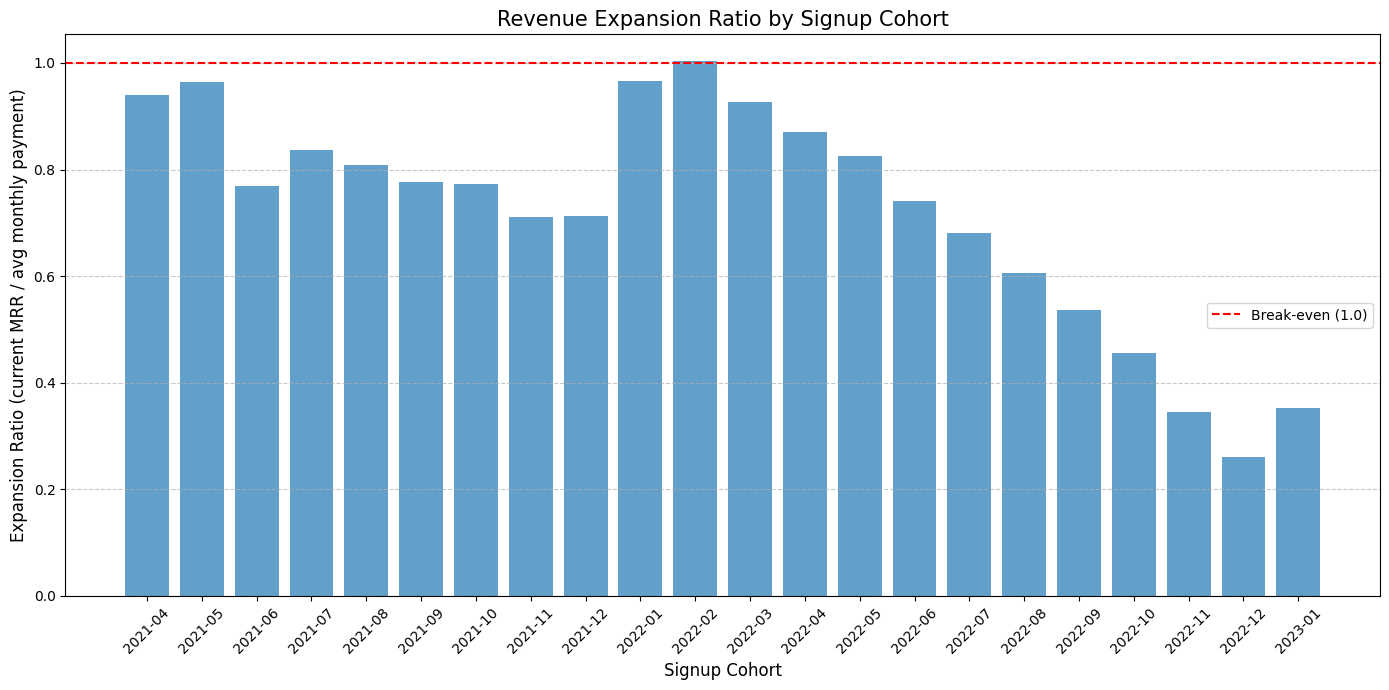

In [104]:
# Calculate expansion metrics by cohort
expansion_analysis = df[(df['converted'] == 1) & (df['is_active'] == 1)].groupby('signup_cohort').apply(
    lambda x: pd.Series({
        'avg_current_mrr': x['current_mrr'].mean(),
        'avg_monthly_payment': x['avg_monthly_payment'].mean(),
        'expansion_ratio': x['current_mrr'].sum() / x['avg_monthly_payment'].sum(),
        'avg_customer_expansion': x['expansion_ratio'].mean(),
        'customers_with_expansion': sum(x['expansion_ratio'] > 1),
        'pct_customers_expanded': sum(x['expansion_ratio'] > 1) / len(x) * 100
    })
).reset_index()

# Plot expansion metrics
plt.figure(figsize=(14, 7))
plt.bar(expansion_analysis['signup_cohort'], expansion_analysis['expansion_ratio'], alpha=0.7)
plt.axhline(y=1.0, color='r', linestyle='--', label='Break-even (1.0)')
plt.title('Revenue Expansion Ratio by Signup Cohort', fontsize=15)
plt.xlabel('Signup Cohort', fontsize=12)
plt.ylabel('Expansion Ratio (current MRR / avg monthly payment)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

/var/folders/7k/wrk7c3wx3pl7px430tg547rr0000gn/T/ipykernel_98169/2663426568.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  net_retention_analysis = df[df['converted'] == 1].groupby('signup_cohort').apply(


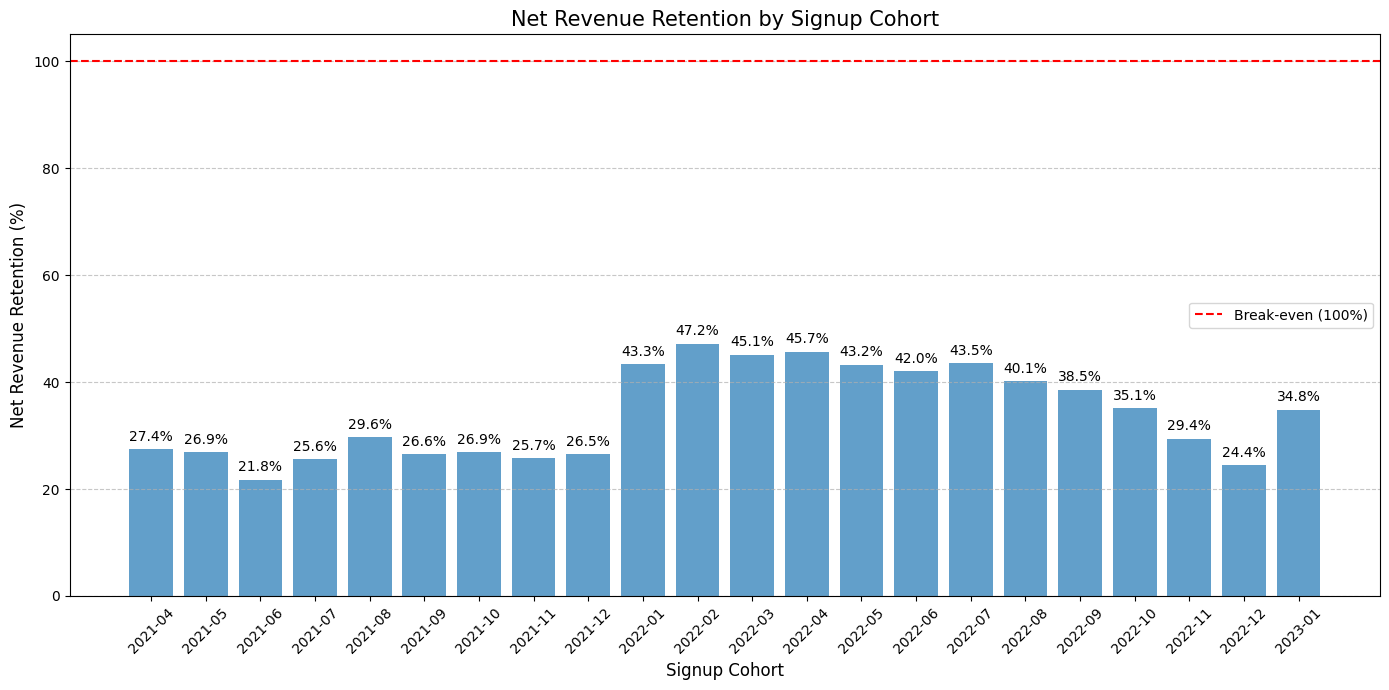

In [105]:
# Calculate Net Revenue Retention (includes expansion)
net_retention_analysis = df[df['converted'] == 1].groupby('signup_cohort').apply(
    lambda x: pd.Series({
        'initial_cohort_mrr': x['avg_monthly_payment'].sum(),
        'current_cohort_mrr': x[x['is_active'] == 1]['current_mrr'].sum(),
        'net_revenue_retention': x[x['is_active'] == 1]['current_mrr'].sum() / x['avg_monthly_payment'].sum() * 100 if x['avg_monthly_payment'].sum() > 0 else 0
    })
).reset_index()

# Plot Net Revenue Retention
plt.figure(figsize=(14, 7))
bars = plt.bar(net_retention_analysis['signup_cohort'], net_retention_analysis['net_revenue_retention'], alpha=0.7)
plt.axhline(y=100, color='r', linestyle='--', label='Break-even (100%)')
plt.title('Net Revenue Retention by Signup Cohort', fontsize=15)
plt.xlabel('Signup Cohort', fontsize=12)
plt.ylabel('Net Revenue Retention (%)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 1,
            f'{height:.1f}%', ha='center', va='bottom')

plt.legend()
plt.tight_layout()
plt.show()

<Figure size 1400x800 with 0 Axes>

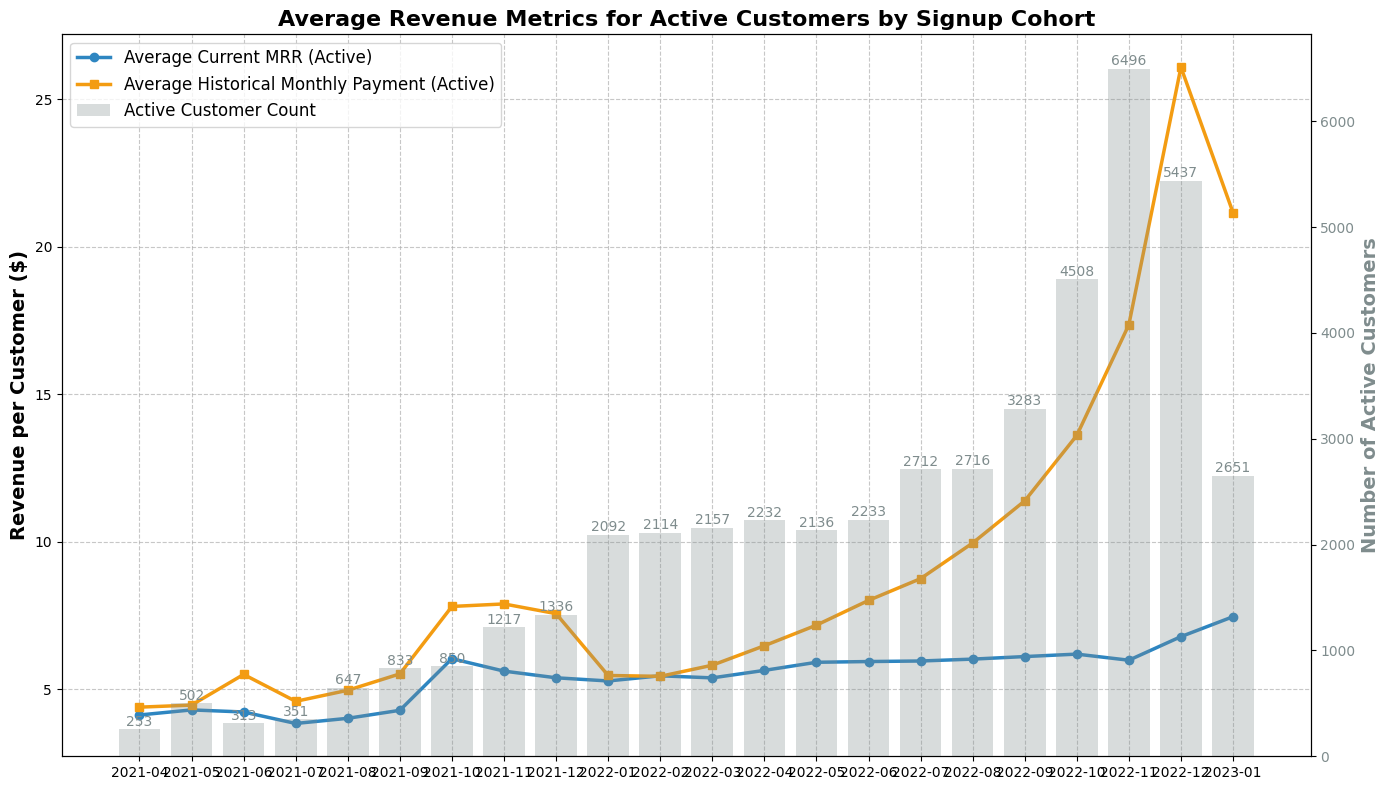

In [107]:
# Create a better visualization for active customers' revenue metrics
plt.figure(figsize=(14, 8))

# Create primary axis for revenue metrics
fig, ax1 = plt.subplots(figsize=(14, 8))

# Plot the revenue metrics with clear labels
ax1.plot(active_cohort_metrics['signup_cohort'], active_cohort_metrics['active_avg_current_mrr'], 'o-', 
         linewidth=2.5, label='Average Current MRR (Active)', color='#2E86C1')
ax1.plot(active_cohort_metrics['signup_cohort'], active_cohort_metrics['active_avg_monthly_payment'], 's-', 
         linewidth=2.5, label='Average Historical Monthly Payment (Active)', color='#F39C12')

# Set up the primary y-axis
ax1.set_ylabel('Revenue per Customer ($)', fontsize=14, fontweight='bold')
ax1.tick_params(axis='y', labelcolor='black')
ax1.grid(True, linestyle='--', alpha=0.7)

# Create secondary axis for customer count
ax2 = ax1.twinx()
bars = ax2.bar(active_cohort_metrics['signup_cohort'], active_cohort_metrics['active_customer_count'], 
        alpha=0.3, color='#7F8C8D', label='Active Customer Count')

# Set up the secondary y-axis
ax2.set_ylabel('Number of Active Customers', fontsize=14, fontweight='bold', color='#7F8C8D')
ax2.tick_params(axis='y', labelcolor='#7F8C8D')

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 5,
            f'{int(height)}', ha='center', va='bottom', color='#7F8C8D')

# Customize the plot
plt.title('Average Revenue Metrics for Active Customers by Signup Cohort', fontsize=16, fontweight='bold')
plt.xlabel('Signup Cohort', fontsize=14, fontweight='bold')
plt.xticks(rotation=45)

# Create combined legend with clear descriptions
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', frameon=True, fontsize=12)

plt.tight_layout()
plt.show()

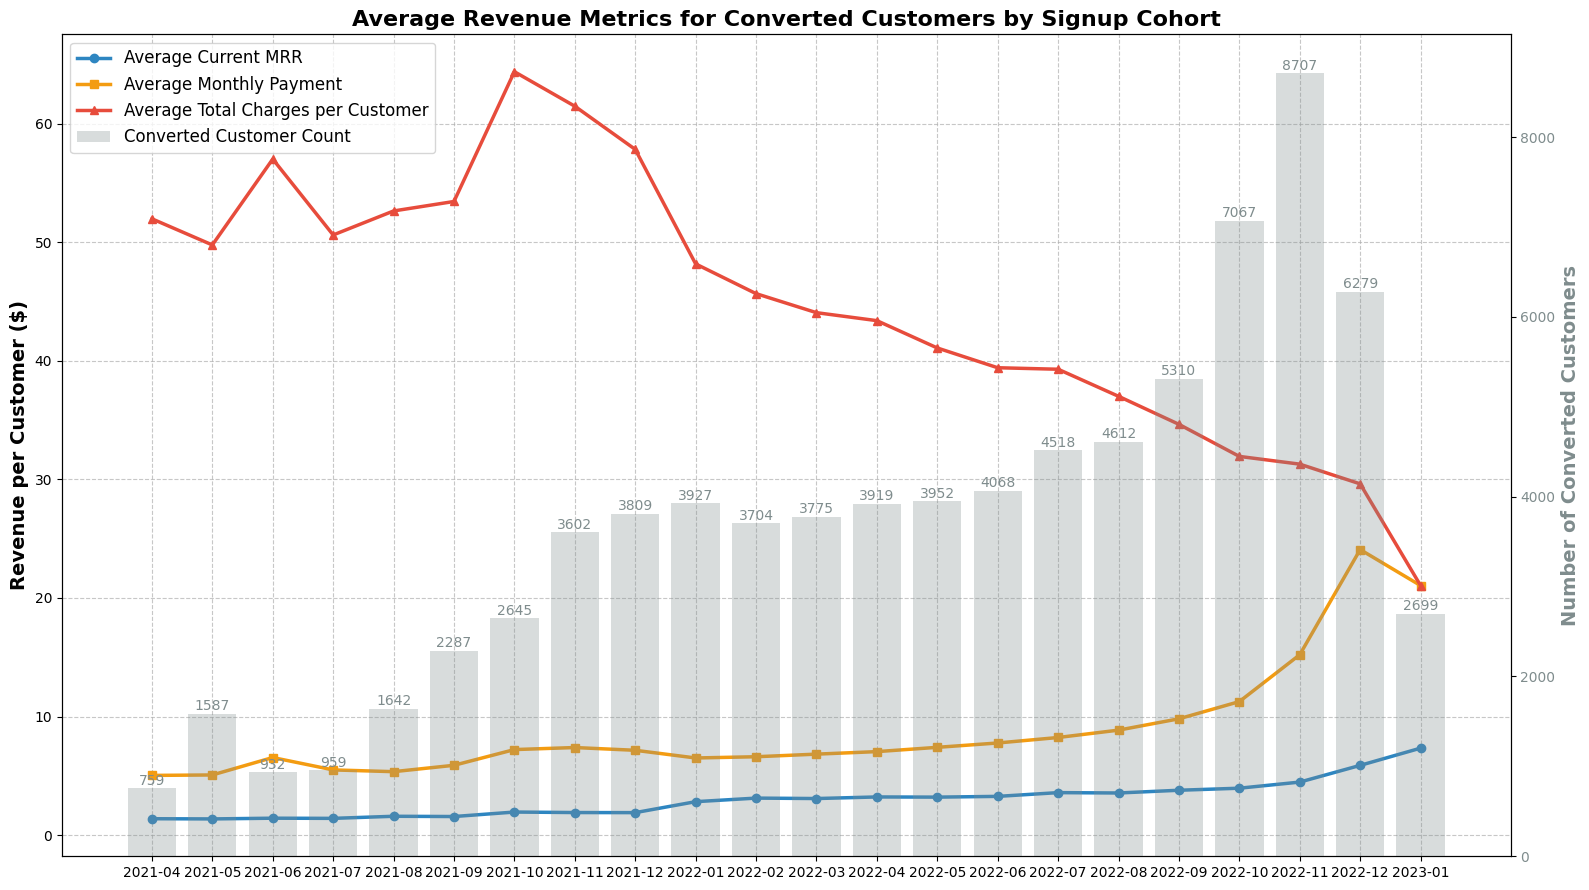

In [111]:
# Create visualization for converted customers' revenue metrics
fig, ax1 = plt.subplots(figsize=(16, 9))  # Increase figure size for more horizontal space

# Plot the revenue metrics with clear labels
ax1.plot(cohort_revenue_metrics['signup_cohort'], cohort_revenue_metrics['avg_current_mrr'], 'o-',
         linewidth=2.5, label='Average Current MRR', color='#2E86C1')
ax1.plot(cohort_revenue_metrics['signup_cohort'], cohort_revenue_metrics['avg_monthly_payment'], 's-',
         linewidth=2.5, label='Average Monthly Payment', color='#F39C12')
ax1.plot(cohort_revenue_metrics['signup_cohort'], cohort_revenue_metrics['avg_total_charges'], '^-',
         linewidth=2.5, label='Average Total Charges per Customer', color='#E74C3C')

# Set up the primary y-axis
ax1.set_ylabel('Revenue per Customer ($)', fontsize=14, fontweight='bold')
ax1.tick_params(axis='y', labelcolor='black')
ax1.grid(True, linestyle='--', alpha=0.7)

# Create secondary axis for customer count
ax2 = ax1.twinx()
bars = ax2.bar(cohort_revenue_metrics['signup_cohort'], cohort_revenue_metrics['customer_count'],
        alpha=0.3, color='#7F8C8D', label='Converted Customer Count')

# Set up the secondary y-axis
ax2.set_ylabel('Number of Converted Customers', fontsize=14, fontweight='bold', color='#7F8C8D')
ax2.tick_params(axis='y', labelcolor='#7F8C8D')

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 5,
            f'{int(height)}', ha='center', va='bottom', color='#7F8C8D')

# Customize the plot
plt.title('Average Revenue Metrics for Converted Customers by Signup Cohort', fontsize=16, fontweight='bold')
plt.xlabel('Signup Cohort', fontsize=14, fontweight='bold')

# Fix the overlapping x-axis labels by making them diagonal - with stronger settings
plt.xticks(rotation=70, ha='right', fontsize=10)  # Steeper angle, right alignment

# Adjust the bottom margin to make room for the diagonal labels
fig.subplots_adjust(bottom=0.25)  # Increase bottom margin significantly

# Create combined legend with clear descriptions
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', frameon=True, fontsize=12)

plt.tight_layout()  # This should respect the bottom margin we set
plt.show()